# Connectomic kernel normative modeling

---

Using a similar methodology to the earlier notebooks in chapter 5, we turn our attention to the random-walk laplacian connectome eigenmodes for normative reconstruction.


### package imports and basic functions

---

In [2]:
import os
import gc
import sys
import glob
import json
import random
import datetime
import importlib
import itertools
import numpy as np
from scipy import spatial
import scipy.sparse as sparse
import scipy.stats as stats
import pandas as pd
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
from tqdm.notebook import tqdm


In [3]:
# pymc libraries
import pymc as pm
import arviz as az
import xarray as xr
import patsy

print(f"Running on PyMC v{pm.__version__}")


Running on PyMC v5.14.0


In [4]:
class MyNumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)


def ensure_dir(file_name):
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
    return file_name


def list_dirs(path=os.getcwd()):
    files = glob.glob(os.path.join(path, '*'))
    files = [x for x in files if os.path.isdir(x)]
    return files


def file_exists(file_name, path_name=os.getcwd()):
    return os.path.isfile(os.path.join(path_name, file_name))


def write_json(json_obj, file_path):
    with open(file_path, 'w') as outfile:
        json.dump(json_obj, outfile, sort_keys=True, indent=4,
                  cls=MyNumpyEncoder)
    return json_obj


def load_json(file_path):
    with open(file_path, 'r') as infile:
        return json.load(infile)


def write_np(np_obj, file_path):
    with open(file_path, 'wb') as outfile:
        np.save(outfile, np_obj)


def load_np(file_path):
    with open(file_path, 'rb') as infile:
        return np.load(infile)


In [5]:
# path setting
main_dir = os.path.abspath('../../../..')
main_dir


'/mountpoint/code/projects/normative_brain_charts'

### Brain visualization functions

---

In [7]:
from nilearn import datasets, surface, plotting
from matplotlib.colors import LinearSegmentedColormap


In [8]:
# basic parameters
surface = 'inflated_MSMAll'
expand = 0

# load an example dscalar
dscalar_file = f'{main_dir}/data/templates/ones.dscalar.nii'
dscalar = nib.load(dscalar_file)

brain_models = [x for x in dscalar.header.get_index_map(1).brain_models]

# load surfaces for visualization
left_surface_file = f'{main_dir}/data/templates/hcp_surf/S1200.L.{surface}.32k_fs_LR.surf.gii'
left_surface = nib.load(left_surface_file)
right_surface_file = f'{main_dir}/data/templates/hcp_surf/S1200.R.{surface}.32k_fs_LR.surf.gii'
right_surface = nib.load(right_surface_file)

# extract surface information
lx, ly, lz = left_surface.darrays[0].data.T
lt = left_surface.darrays[1].data
rx, ry, rz = right_surface.darrays[0].data.T
rt = right_surface.darrays[1].data

# combine into a complete brain
lrx = np.concatenate([lx - expand, rx + expand])
lry = np.concatenate([ly, ry])
lrz = np.concatenate([lz, rz])
lrt = np.concatenate([lt, (rt + lx.shape[0])])

lxyz = left_surface.darrays[0].data
rxyz = right_surface.darrays[0].data
lrxyz = np.array([lrx, lry, lrz]).T

# create a mapping between surface and cifti vertices
left_cortical_surface_model, right_cortical_surface_model = brain_models[0], brain_models[1]
cifti_to_surface = {}
surface_to_cifti = {}
for (i, x) in enumerate(left_cortical_surface_model.vertex_indices):
    cifti_to_surface[i] = x
    surface_to_cifti[x] = i
for (i, x) in enumerate(right_cortical_surface_model.vertex_indices):
    cifti_to_surface[i + right_cortical_surface_model.index_offset] = x + rx.shape[0]
    surface_to_cifti[x + rx.shape[0]] = i + right_cortical_surface_model.index_offset

# construct data over surface
surface_mask = list(surface_to_cifti.keys())


In [9]:
# arbitrary colormap
mycm = LinearSegmentedColormap.from_list(
    'my_gradient',
    (
        (0.0, (0.1, 0.1, 1.,)),
        # (0.4999, (0.9, 0.9, 1.,)),
        (0.25, (0.1, 1., 1.,)),
        # (0.4999, (0.9, 1., 1.,)),
        (0.5, (1., 1., 1.,)),
        # (0.5001, (1., 1., 0.9,)),
        (0.75, (1., 1., 0.1,)),
        # (0.5001, (1., 0.9, 0.9,)),
        (1.0, (1., 0.1, 0.1,)),
    )
)

mycm_dark = LinearSegmentedColormap.from_list(
    'my_gradient',
    (
        (0.0, (0.05, 1., 1.,)),
        (0.35, (0.05, 0.05, 1.,)),
        (0.5, (0.2, 0.05, 0.05,)),
        (0.65, (1., 0.05, 0.05,)),
        (1.0, (1., 1., 0.05,)),
    )
)

# ignore warning when loading cifti
nib.imageglobals.logger.setLevel(40)

# load sulcal depth for background
sulcal_depth = nib.load(f"{main_dir}/data/templates/hcp_surf/S1200.sulc_MSMAll.32k_fs_LR.dscalar.nii")


# visualization via nilearn
def plot_data_on_brain_surface(data, title="", cmap=mycm, symmetric_cbar=True, vmax=None, vmin=None, background_data=sulcal_depth.get_fdata()[0], darkness=0.1, auto_vlim_quantile=0.05, colorbar_format=None):
    """
    Plot a cifti-like data over the fs-LR32k surface space.
    ----------------------------------------------------------------
    Parameters:
        - data: a vector of shape (59412,) to be visualized.
        - title: the title of generated plot.
        - cmap: the colormap used for the plot.
        - symmetric_cbar: bool, Specifies whether the 
          colorbar should be symmetric (centered at zero).
        - vmax: colorbar max limit.
        - vmin: colorbar min limit.
        - background data: a surface data to project as a shadow
          behind the main data. (use None for no background)
        - darkness: the background effect
        - auto_vlim_quantile: the quantile to define vmin and vmax
          automatically (should be in the range of [0,0.5)]).
        - colorbar_format: string format for numbers in colorbar.
    ----------------------------------------------------------------
    """
    # Initialization
    if vmax is None:
        vmax = np.quantile(data,1 - auto_vlim_quantile)
    if vmin is None:
        vmin = np.quantile(data,auto_vlim_quantile)
    if symmetric_cbar:
        (vmin, vmax) = -max(abs(vmin), abs(vmax)), max(abs(vmin), abs(vmax))
    if background_data is not None:
        background = True
    else:
        background = False
    
    # surface center
    cxyz=(lrxyz.min(0) + lrxyz.max(0))/2

    # transfer data to surface scalar
    surface_scalars = np.empty(lrx.shape[0])
    surface_scalars[:] = np.nan
    surface_scalars[surface_mask] = data.copy()

    # decompose left and right information
    left_surface_scalars = surface_scalars[:lx.shape[0]]
    right_surface_scalars = surface_scalars[-rx.shape[0]:]
    
    # Generate background data
    surface_background_data = np.zeros(lrx.shape[0])
    surface_background_data[surface_mask] = background_data.copy()
    left_background_data = surface_background_data[:lx.shape[0]]
    right_background_data = surface_background_data[-rx.shape[0]:]


    fig, axes = plt.subplots(2, 2, figsize=(8, 8), subplot_kw={'projection': '3d'});

    zoom_coeff = 0.85

    # 'lateral', 'medial', 'dorsal', 'ventral', 'anterior', 'posterior'
    plotting.plot_surf(
        [lxyz-cxyz, lt],
        left_surface_scalars,
        axes=axes[0,0],
        view='lateral',
        colorbar=False,
        symmetric_cbar=False,
        darkness=darkness,
        vmax=vmax,
        vmin=vmin,
        cmap=cmap,
        bg_on_data=background,
        bg_map=left_background_data,
    );
    axes[0,0].set_xlim3d(np.array(axes[0,0].get_xlim3d())*zoom_coeff)
    axes[0,0].set_ylim3d(np.array(axes[0,0].get_ylim3d())*zoom_coeff)
    axes[0,0].set_zlim3d(np.array(axes[0,0].get_zlim3d())*zoom_coeff)

    plotting.plot_surf(
        [rxyz-cxyz, rt],
        right_surface_scalars,
        axes=axes[0,1],
        view='medial',
        colorbar=False,
        symmetric_cbar=False,
        darkness=darkness,
        vmax=vmax,
        vmin=vmin,
        cmap=cmap,
        bg_on_data=background,
        bg_map=right_background_data,
    );
    axes[0,1].set_xlim3d(np.array(axes[0,1].get_xlim3d())*zoom_coeff)
    axes[0,1].set_ylim3d(np.array(axes[0,1].get_ylim3d())*zoom_coeff)
    axes[0,1].set_zlim3d(np.array(axes[0,1].get_zlim3d())*zoom_coeff)


    plotting.plot_surf(
        [lxyz-cxyz, lt],
        left_surface_scalars,
        axes=axes[1,0],
        view='medial',
        colorbar=False,
        symmetric_cbar=False,
        darkness=darkness,
        vmax=vmax,
        vmin=vmin,
        cmap=cmap,
        bg_on_data=background,
        bg_map=left_background_data,
    );
    axes[1,0].set_xlim3d(np.array(axes[1,0].get_xlim3d())*zoom_coeff)
    axes[1,0].set_ylim3d(np.array(axes[1,0].get_ylim3d())*zoom_coeff)
    axes[1,0].set_zlim3d(np.array(axes[1,0].get_zlim3d())*zoom_coeff)

    plotting.plot_surf(
        [rxyz-cxyz, rt],
        right_surface_scalars,
        axes=axes[1,1],
        view='lateral',
        colorbar=False,
        symmetric_cbar=False,
        darkness=darkness,
        vmax=vmax,
        vmin=vmin,
        cmap=cmap,
        bg_on_data=background,
        bg_map=right_background_data,
    );
    axes[1,1].set_xlim3d(np.array(axes[1,1].get_xlim3d())*zoom_coeff)
    axes[1,1].set_ylim3d(np.array(axes[1,1].get_ylim3d())*zoom_coeff)
    axes[1,1].set_zlim3d(np.array(axes[1,1].get_zlim3d())*zoom_coeff)

    fig.suptitle(title, fontsize=24, y=0.98);
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=-0., hspace=-0.25)

    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    axins = inset_axes(
        axes[0,0],
        width="30%",
        height="4%",
        loc="center",
        bbox_to_anchor=(-0., 0.02, 1., 1.),
        bbox_transform=fig.transFigure,
        borderpad=0,
    )
    cb = fig.colorbar(
        mpl.cm.ScalarMappable(
            norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax),
            cmap=cmap
        ),
        cax=axins,
        aspect=10,
        orientation='horizontal',
        format=colorbar_format,
    )
    cb.outline.set_visible(False)
    cb.ax.tick_params(labelsize=12)
    cb.ax.tick_params(length=0)


## Load aggregated data

---

In [8]:
demography_df = pd.read_csv(f'{main_dir}/data/csv/demography_all_datasets.csv', index_col=0).reset_index(drop=True)
demography_df.head()


age  thickness  sex     subject_ID dataset           site  siteCode  \
0  32.0   2.636395  1.0  HCP-YA-130518  HCP-YA  HCP-YA-site_0         0   
1  35.0   2.633850  1.0  HCP-YA-192237  HCP-YA  HCP-YA-site_0         0   
2  31.0   2.704905  1.0  HCP-YA-859671  HCP-YA  HCP-YA-site_0         0   
3  33.0   2.629196  0.0  HCP-YA-158136  HCP-YA  HCP-YA-site_0         0   
4  22.0   2.760889  0.0  HCP-YA-192136  HCP-YA  HCP-YA-site_0         0   

   split  age_bins  
0  Train        11  
1  Train        13  
2  Train        10  
3  Train        12  
4   Test         5

## Load high-resolution thickness data

---

In [9]:
all_thickness_data = load_np(f'{main_dir}/data/npy/thickness_all_datasets.npy');
all_thickness_data.shape


(2473, 59412)

## Load the connectome kernel

---

In [10]:
# store the computed kernel
connectome_kernel_eigenvalues = load_np(f'{main_dir}/data/npy/rw_cortical_connectome_eigenvalues_cifti.npy');
connectome_kernel_eigenvectors = load_np(f'{main_dir}/data/npy/rw_cortical_connectome_eigenvectors_cifti.npy');


## Encode the high-resolution data by kernel and attach to the demography data

---

In [12]:
# center the data prior to encoding
all_thickness_data_encoded = np.dot(all_thickness_data, connectome_kernel_eigenvectors)
all_thickness_data_encoded.shape


(2473, 11001)

In [21]:
demography_extended_df = pd.concat(
    [
        demography_df,
        pd.DataFrame(
            all_thickness_data_encoded,
            columns=[f'thickness_connectome_pc_{i}' for i in range(all_thickness_data_encoded.shape[1])],
        ),
    ],
    axis=1,
)

demography_extended_df.head()


age  thickness  sex     subject_ID dataset           site  siteCode  \
0  32.0   2.636395  1.0  HCP-YA-130518  HCP-YA  HCP-YA-site_0         0   
1  35.0   2.633850  1.0  HCP-YA-192237  HCP-YA  HCP-YA-site_0         0   
2  31.0   2.704905  1.0  HCP-YA-859671  HCP-YA  HCP-YA-site_0         0   
3  33.0   2.629196  0.0  HCP-YA-158136  HCP-YA  HCP-YA-site_0         0   
4  22.0   2.760889  0.0  HCP-YA-192136  HCP-YA  HCP-YA-site_0         0   

   split  age_bins  thickness_connectome_pc_0  ...  \
0  Train        11                 638.317953  ...   
1  Train        13                 638.414616  ...   
2  Train        10                 654.864170  ...   
3  Train        12                 637.810719  ...   
4   Test         5                 668.436694  ...   

   thickness_connectome_pc_10991  thickness_connectome_pc_10992  \
0                      -1.662911                       1.787276   
1                      -1.825474                       3.682971   
2                      -0.983072                       0.785621   
3                      -1.356791                       2.256942   
4                      -1.205406                       1.260074   

   thickness_connectome_pc_10993  thickness_connectome_pc_10994  \
0                      -1.608222                       0.199413   
1                      -0.730564                       1.435097   
2                       1.060457                       1.273249   
3                       1.217908                       1.548140   
4                       0.885699                      -0.261467   

   thickness_connectome_pc_10995  thickness_connectome_pc_10996  \
0                       0.441473                      -3.713487   
1                       2.041324                      -0.704695   
2                       4.897137                      -2.339988   
3                       2.517531                      -1.626829   
4                       4.468548                      -1.648583   

   thickness_connectome_pc_10997  thickness_connectome_pc_10998  \
0                       2.244974                      -4.719631   
1                       1.891646                      -4.744670   
2                       1.849339                      -2.094456   
3                       3.657613                      -2.599234   
4                       6.101078                      -2.757358   

   thickness_connectome_pc_10999  thickness_connectome_pc_11000  
0                       2.746984                      -2.302242  
1                      -0.274023                      -3.100237  
2                       1.724501                      -2.641834  
3                       1.881268                      -0.680960  
4                       1.166948                      -3.312382  

[5 rows x 11010 columns]

## Visualize encoded thickness data

---

CPU times: user 183 ms, sys: 94 ms, total: 277 ms
Wall time: 127 ms


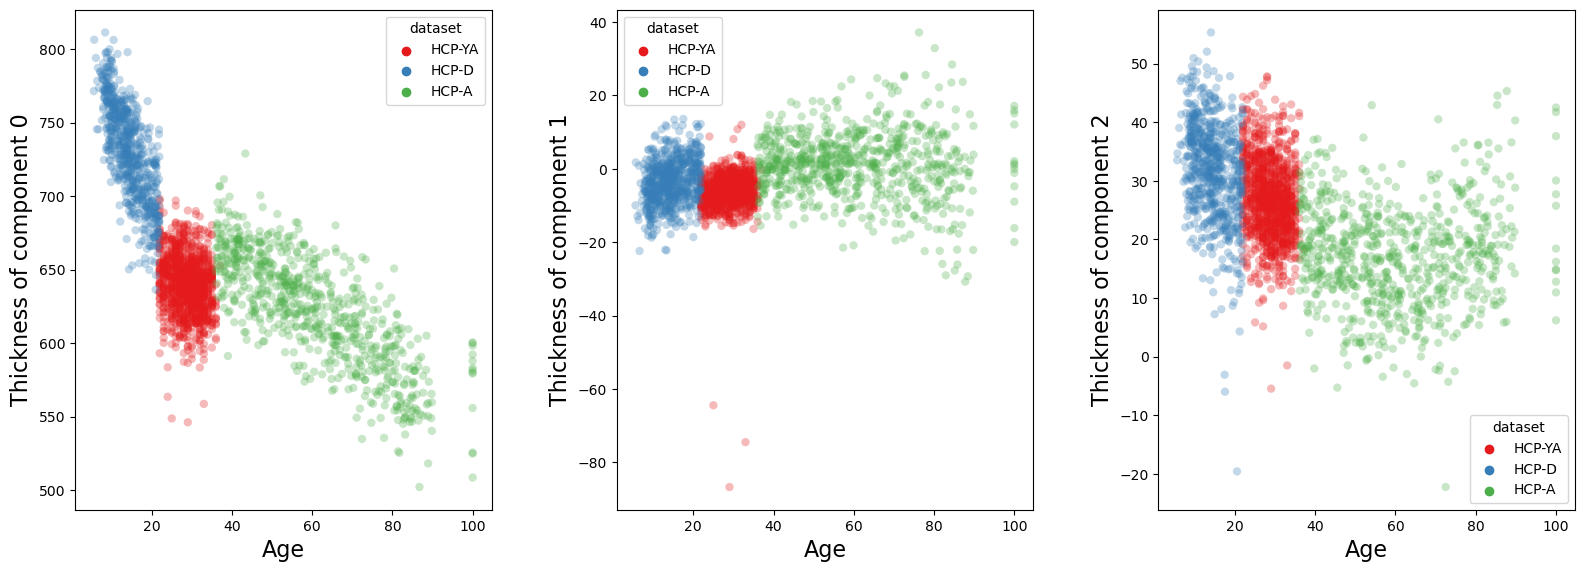

In [15]:
%%time

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for c in range(3):
    ax = axes[c]
    sns.scatterplot(
        data=demography_extended_df,
        x='age',
        y=f'thickness_connectome_pc_{c}',
        ax=ax,
        linewidth=0,
        hue='dataset',
        palette="Set1",
        alpha = 0.3,
    )

    ax.set_xlabel('Age', fontsize=16)
    ax.set_ylabel(f'Thickness of component {c}', fontsize=16)

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.)


CPU times: user 193 ms, sys: 88.2 ms, total: 281 ms
Wall time: 126 ms


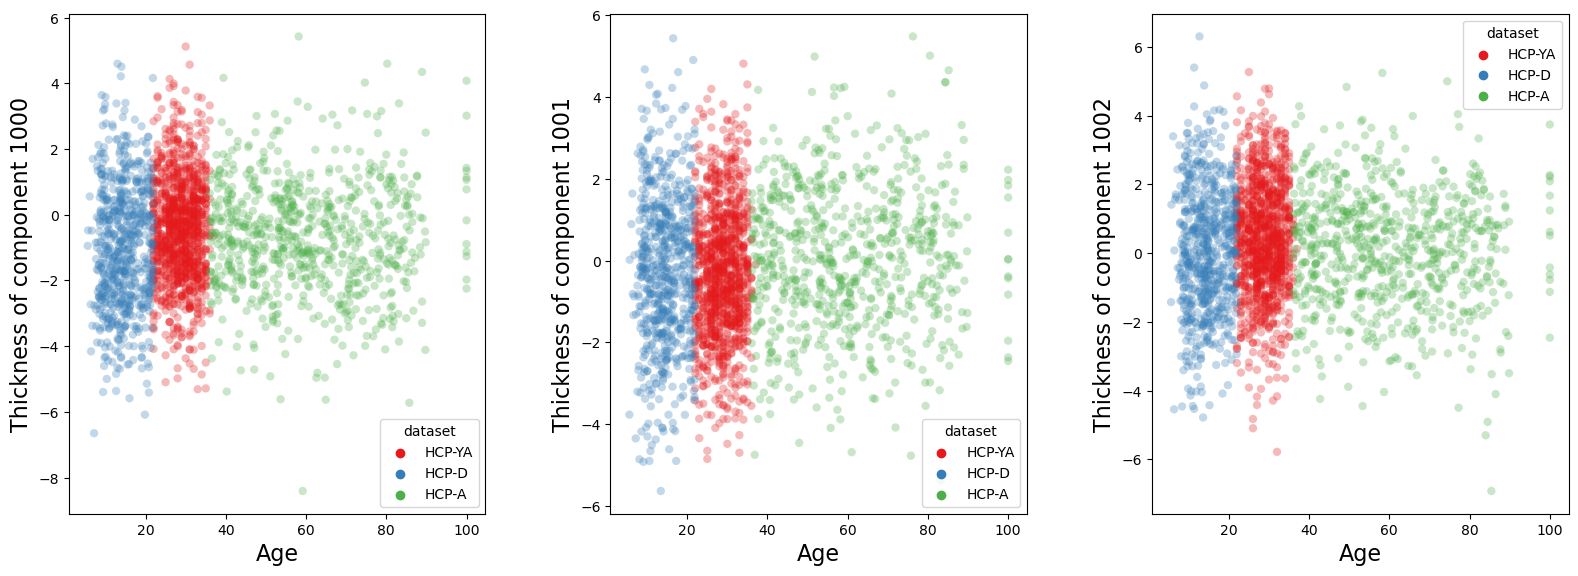

In [16]:
%%time

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for c in range(3):
    ax = axes[c]
    sns.scatterplot(
        data=demography_extended_df,
        x='age',
        y=f'thickness_connectome_pc_{c+1000}',
        ax=ax,
        linewidth=0,
        hue='dataset',
        palette="Set1",
        alpha = 0.3,
    )

    ax.set_xlabel('Age', fontsize=16)
    ax.set_ylabel(f'Thickness of component {c+1000}', fontsize=16)

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.)


## Train test split

---

In [25]:
train_set =  (demography_extended_df['split'] == "Train")
train_df = demography_extended_df[train_set]
test_df = demography_extended_df[~train_set]
train_df.head()


age  thickness  sex     subject_ID dataset           site  siteCode  \
0  32.0   2.636395  1.0  HCP-YA-130518  HCP-YA  HCP-YA-site_0         0   
1  35.0   2.633850  1.0  HCP-YA-192237  HCP-YA  HCP-YA-site_0         0   
2  31.0   2.704905  1.0  HCP-YA-859671  HCP-YA  HCP-YA-site_0         0   
3  33.0   2.629196  0.0  HCP-YA-158136  HCP-YA  HCP-YA-site_0         0   
5  34.0   2.574035  1.0  HCP-YA-654754  HCP-YA  HCP-YA-site_0         0   

   split  age_bins  thickness_connectome_pc_0  ...  \
0  Train        11                 638.317953  ...   
1  Train        13                 638.414616  ...   
2  Train        10                 654.864170  ...   
3  Train        12                 637.810719  ...   
5  Train        13                 623.471748  ...   

   thickness_connectome_pc_10991  thickness_connectome_pc_10992  \
0                      -1.662911                       1.787276   
1                      -1.825474                       3.682971   
2                      -0.983072                       0.785621   
3                      -1.356791                       2.256942   
5                      -1.751002                       0.672668   

   thickness_connectome_pc_10993  thickness_connectome_pc_10994  \
0                      -1.608222                       0.199413   
1                      -0.730564                       1.435097   
2                       1.060457                       1.273249   
3                       1.217908                       1.548140   
5                       2.415167                       0.134885   

   thickness_connectome_pc_10995  thickness_connectome_pc_10996  \
0                       0.441473                      -3.713487   
1                       2.041324                      -0.704695   
2                       4.897137                      -2.339988   
3                       2.517531                      -1.626829   
5                       5.528815                      -3.434725   

   thickness_connectome_pc_10997  thickness_connectome_pc_10998  \
0                       2.244974                      -4.719631   
1                       1.891646                      -4.744670   
2                       1.849339                      -2.094456   
3                       3.657613                      -2.599234   
5                       0.586962                      -5.114632   

   thickness_connectome_pc_10999  thickness_connectome_pc_11000  
0                       2.746984                      -2.302242  
1                      -0.274023                      -3.100237  
2                       1.724501                      -2.641834  
3                       1.881268                      -0.680960  
5                       2.530922                      -2.909750  

[5 rows x 11010 columns]

## Create a fixed BSpline function to ensure consistent nonlinear expansions of age across all models

---



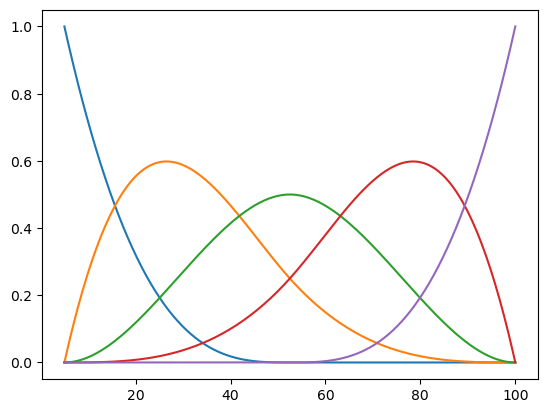

In [621]:
# fixed B-spline
age_min=5
age_max=100
num_knots = 3
patsy_knots = np.linspace(age_min, age_max, num_knots)[1:-1]
fixed_B_spline_age = patsy.dmatrix(
    "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
    {"xi": (np.linspace(age_min, age_max, 200)), "knots": patsy_knots},
)
plt.plot(np.linspace(age_min, age_max, 200), fixed_B_spline_age)


In [ ]:
# fixed B-spline
age_min=60
age_max=100
num_knots = 3
patsy_knots = np.linspace(age_min, age_max, num_knots)[1:-1]
fixed_B_spline_age = patsy.dmatrix(
    "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
    {"xi": (np.linspace(age_min, age_max, 200)), "knots": patsy_knots},
)
plt.plot(np.linspace(age_min, age_max, 200), fixed_B_spline_age)


In [ ]:
1

## Run parallel models to fit normative distributions for every kernel

---

In [169]:
# # old code before fixing the spline expansion
# # random seed for reproducibility
# rng = np.random.default_rng(12345)

# def run_pymc_advi_on_kernel(kernel_name, train_df=train_df):
#     # sample from required columns
#     sample_df = train_df[['age', 'site', 'sex', kernel_name]].copy()

#     # Data preperation
#     age = sample_df['age'].values
#     age_standardized = (age - age.mean()) / age.std()
#     thickness = sample_df[kernel_name].values
#     thickness_standardized = (thickness - thickness.mean()) / thickness.std()
#     site_idxs, sites = pd.factorize(sample_df['site'])
#     sex_idxs, sexes = pd.factorize(sample_df['sex'])
   
#     # Splines to model nonlinear age effects on thickness
#     # number of spline nuts (could be tuned)
#     num_knots = 3
#     knot_list = np.quantile(age_standardized, np.linspace(0, 1, num_knots))
#     # create b spline basis for regression using patsy
#     B_spline_age = patsy.dmatrix(
#         "bs(age_standardized, knots=knots, degree=3, include_intercept=True) - 1",
#         {"age_standardized": age_standardized, "knots": knot_list[1:-1]},
#     )

#     coords = {
#         "site": sites,
#         "sex": sexes,
#         "splines": np.arange(B_spline_age.shape[1]),
#         "obs_id": np.arange(len(site_idxs)),
#     }

#     kernel_advi_model = pm.Model(coords=coords, aesara_config={'compute_test_value': 'off'})
#     # models_dict[kernel_name] = advi_model

#     # a nonlinear spline model (see https://www.pymc.io/projects/examples/en/latest/case_studies/spline.html)
#     with kernel_advi_model:
#         # minibatch variables
#         age_standardized_t = pm.Minibatch(age_standardized, 512,)
#         sex_idx_t = pm.Minibatch(sex_idxs, 512)
#         site_idx_t = pm.Minibatch(site_idxs, 512)
#         B_spline_age_t = pm.Minibatch(B_spline_age, 512)
#         thickness_standardized_t = pm.Minibatch(thickness_standardized, 512)

#         # Hyperpriors for site groups (as if we have random group effects)
#         mu_intercept_site = pm.Normal('mu_intercept_site', mu=0, sigma=10)
#         sigma_intercept_site = pm.HalfNormal("sigma_intercept_site", sigma=10)
#         sigma_error_site = pm.HalfNormal("sigma_error_site", sigma=10)

#         # Priors    
#         # sex effects (similar to fixed sex effects (intercept only))
#         intercept_sex = pm.Normal("intercept_sex", mu=0, sigma=10, dims="sex")

#         # site effects (similar to random site effects (intercept only))
#         #a_site = pm.Normal("a_site", mu=mu_a_site, sigma=sigma_a_site, dims="site")
#         intercept_site_offset = pm.Normal("intercept_site_offset", mu=0, sigma=1, dims="site")
#         intercept_site = pm.Deterministic("intercept_site", mu_intercept_site + intercept_site_offset * sigma_intercept_site, dims="site")

#         # age splines
#         w_age = pm.Normal("w_age", mu=0, sigma=10, size=B_spline_age.shape[1], dims="splines")

#         # Estimated thickness
#         # thickness_est = pm.Deterministic("thickness_est", intercept_sex[sex_idx_t] + intercept_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_age.T))
#         thickness_est = intercept_sex[sex_idx_t] + intercept_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_age.T)

#         # Model error
#         # nonlinear age error
#         w_error_age = pm.HalfCauchy("w_error_age", beta=5, size=B_spline_age.shape[1], dims="splines")

#         # constant sex error
#         error_sex = pm.HalfCauchy("error_sex", beta=5, dims="sex")

#         # random site error
#         error_site_offset = pm.HalfCauchy("error_site_offset", beta=5, dims="site")
#         error_site = pm.Deterministic("error_site", error_site_offset * sigma_error_site, dims="site")

#         # Error estimate
#         # thickness_error = pm.Deterministic("thickness_error", error_sex[sex_idx_t] + error_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age.T))
#         thickness_error = error_sex[sex_idx_t] + error_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age.T)

#         # Skewness estimate
#         # thickness_skewness = pm.Normal("thickness_skewness", mu=0, sigma=10, total_size=len(sample_df))
#         # for sake of simplicity let's not model skewness

#         # Likelihood (sampling distribution) of observations
#         # need to figure out how to bound the distribution
#         # pm.Bound("thickness_like", pm.Normal, lower=(-thickness.mean() / thickness.std()))(
#         # thickness_like = pm.SkewNormal(
#         thickness_like = pm.Normal(
#             "thickness_like",
#             mu=thickness_est,
#             sigma=thickness_error,
#             observed=thickness_standardized_t,
#             total_size=len(sample_df),
#         )
#             # alpha=thickness_skewness,
    
#         # run ADVI with minibatch
#         kernel_approx = pm.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)], random_seed=12345)

#         # sample from trace
#         kernel_advi_model_idata = pm.sample_prior_predictive(random_seed=rng)
#         kernel_advi_model_idata.extend(kernel_approx.sample(2000, random_seed=rng))
#         pm.sample_posterior_predictive(kernel_advi_model_idata, extend_inferencedata=True, random_seed=rng)
#         # idata_dict[kernel_name] = advi_model_idata
    
#     stored_model_file = f'{main_dir}/data/models/pymc/connectome_rw_kernel/{kernel_name}_pymc_advi.nc'
#     kernel_advi_model_idata.to_netcdf(ensure_dir(stored_model_file))
#     return (kernel_name, stored_model_file)
    

In [685]:
# random seed for reproducibility
rng = np.random.default_rng(12345)

def run_pymc_advi_on_kernel(kernel_name, train_df=train_df, fixed_B_spline_age=fixed_B_spline_age):
    # sample from required columns
    sample_df = train_df[['age', 'site', 'sex', kernel_name]].copy()

    # Data preperation
    age = sample_df['age'].values
    # age_standardized = (age - age.mean()) / age.std()
    thickness = sample_df[kernel_name].values
    thickness_standardized = (thickness - thickness.mean()) / thickness.std()
    site_idxs, sites = pd.factorize(sample_df['site'])
    sex_idxs, sexes = pd.factorize(sample_df['sex'])
   
    # Splines to model nonlinear age effects on thickness
    # Using the fixed B-Spline, no need to standardize age range
    B_spline_age = patsy.build_design_matrices(
        [fixed_B_spline_age.design_info],
        {"xi": age, "knots": patsy_knots}
    )[0]
    
    
    coords = {
        "site": sites,
        "sex": sexes,
        "splines": np.arange(B_spline_age.shape[1]),
        "obs_id": np.arange(len(site_idxs)),
    }

    kernel_advi_model = pm.Model(coords=coords, aesara_config={'compute_test_value': 'off'})
    # models_dict[kernel_name] = advi_model

    # a nonlinear spline model (see https://www.pymc.io/projects/examples/en/latest/case_studies/spline.html)
    with kernel_advi_model:
        # minibatch variables
        # age_t = pm.Minibatch(age, 512,)
        sex_idx_t = pm.Minibatch(sex_idxs, 512)
        site_idx_t = pm.Minibatch(site_idxs, 512)
        B_spline_age_t = pm.Minibatch(B_spline_age, 512)
        thickness_standardized_t = pm.Minibatch(thickness_standardized, 512)

        # Hyperpriors for site groups (as if we have random group effects)
        mu_intercept_site = pm.Normal('mu_intercept_site', mu=0, sigma=10)
        sigma_intercept_site = pm.HalfNormal("sigma_intercept_site", sigma=10)
        sigma_error_site = pm.HalfNormal("sigma_error_site", sigma=10)

        # Priors    
        # sex effects (similar to fixed sex effects (intercept only))
        intercept_sex = pm.Normal("intercept_sex", mu=0, sigma=10, dims="sex")

        # site effects (similar to random site effects (intercept only))
        #a_site = pm.Normal("a_site", mu=mu_a_site, sigma=sigma_a_site, dims="site")
        intercept_site_offset = pm.Normal("intercept_site_offset", mu=0, sigma=1, dims="site")
        intercept_site = pm.Deterministic("intercept_site", mu_intercept_site + intercept_site_offset * sigma_intercept_site, dims="site")

        # age splines
        w_age = pm.Normal("w_age", mu=0, sigma=10, size=B_spline_age.shape[1], dims="splines")

        # Estimated thickness
        # thickness_est = pm.Deterministic("thickness_est", intercept_sex[sex_idx_t] + intercept_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_age.T))
        thickness_est = intercept_sex[sex_idx_t] + intercept_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_age.T)

        # Model error
        # nonlinear age error
        w_error_age = pm.HalfCauchy("w_error_age", beta=5, size=B_spline_age.shape[1], dims="splines")

        # constant sex error
        error_sex = pm.HalfCauchy("error_sex", beta=5, dims="sex")

        # random site error
        error_site_offset = pm.HalfCauchy("error_site_offset", beta=5, dims="site")
        error_site = pm.Deterministic("error_site", error_site_offset * sigma_error_site, dims="site")

        # Error estimate
        # thickness_error = pm.Deterministic("thickness_error", error_sex[sex_idx_t] + error_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age.T))
        thickness_error = error_sex[sex_idx_t] + error_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age.T)

        # Skewness estimate
        # thickness_skewness = pm.Normal("thickness_skewness", mu=0, sigma=10, total_size=len(sample_df))
        # for sake of simplicity let's not model skewness

        # Likelihood (sampling distribution) of observations
        # need to figure out how to bound the distribution
        # pm.Bound("thickness_like", pm.Normal, lower=(-thickness.mean() / thickness.std()))(
        # thickness_like = pm.SkewNormal(
        thickness_like = pm.Normal(
            "thickness_like",
            mu=thickness_est,
            sigma=thickness_error,
            observed=thickness_standardized_t,
            total_size=len(sample_df),
        )
            # alpha=thickness_skewness,
    
        # run ADVI with minibatch
        kernel_approx = pm.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)], random_seed=12345)

        # sample from trace
        kernel_advi_model_idata = pm.sample_prior_predictive(random_seed=rng)
        kernel_advi_model_idata.extend(kernel_approx.sample(2000, random_seed=rng))
        pm.sample_posterior_predictive(kernel_advi_model_idata, extend_inferencedata=True, random_seed=rng)
        # idata_dict[kernel_name] = advi_model_idata
            
        # store constants for observed mean and std used for standardization (added as a new group to inference data)
        kernel_advi_model_idata.add_groups({
            "training": {
                'thickness_mean': thickness.mean(),
                'thickness_std': thickness.std(),
                'sample_size': thickness.shape[0],
            },
        })
    
    stored_model_file = f'{main_dir}/data/models/pymc/connectome_rw_kernel/{kernel_name}_pymc_advi.nc'
    kernel_advi_model_idata.to_netcdf(ensure_dir(stored_model_file))
    return (kernel_name, stored_model_file)
    

In [686]:
run_pymc_advi_on_kernel('thickness_connectome_pc_0')

Finished [100%]: Average Loss = 295.98
Sampling: [error_sex, error_site_offset, intercept_sex, intercept_site_offset, mu_intercept_site, sigma_error_site, sigma_intercept_site, thickness_like, w_age, w_error_age]
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation thickness_like
  warnings.warn(f"Could not extract data from symbolic observation {obs}")
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation thickness_like
  warnings.warn(f"Could not extract data from symbolic observation {obs}")
Sampling: [thickness_like]


/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation thickness_like
  warnings.warn(f"Could not extract data from symbolic observation {obs}")
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/arviz/data/inference_data.py:1361: UserWarning: The group training is not defined in the InferenceData scheme
  warnings.warn(
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/arviz/data/inference_data.py:1372: UserWarning: the default dims 'chain' and 'draw' will be added automatically
  warnings.warn(


('thickness_connectome_pc_0',
 '/mountpoint/code/projects/normative_brain_charts/data/models/pymc/connectome_rw_kernel/thickness_connectome_pc_0_pymc_advi.nc')

In [ ]:
%%capture multiprocessing_log

import multiprocessing
import time

def mute():
    sys.stdout = open(os.devnull, 'w')

PROCESSES = 32
with multiprocessing.Pool(PROCESSES, initializer=mute) as pool:
    collected_results = pool.map(
        run_pymc_advi_on_kernel,
        [f'thickness_connectome_pc_{i}' for i in range(all_thickness_data_encoded.shape[1])]
    )


Finished [100%]: Average Loss = 742.79
Sampling: [error_sex, error_site_offset, intercept_sex, intercept_site_offset, mu_intercept_site, sigma_error_site, sigma_intercept_site, thickness_like, w_age, w_error_age]
Finished [100%]: Average Loss = 735.06
Sampling: [error_sex, error_site_offset, intercept_sex, intercept_site_offset, mu_intercept_site, sigma_error_site, sigma_intercept_site, thickness_like, w_age, w_error_age]
Finished [100%]: Average Loss = 745.33
Sampling: [error_sex, error_site_offset, intercept_sex, intercept_site_offset, mu_intercept_site, sigma_error_site, sigma_intercept_site, thickness_like, w_age, w_error_age]
Finished [100%]: Average Loss = 748.33
Finished [100%]: Average Loss = 744.46
Sampling: [error_sex, error_site_offset, intercept_sex, intercept_site_offset, mu_intercept_site, sigma_error_site, sigma_intercept_site, thickness_like, w_age, w_error_age]
Sampling: [error_sex, error_site_offset, intercept_sex, intercept_site_offset, mu_intercept_site, sigma_error

In [729]:
target_date = datetime.datetime.strptime("2023-12-20", "%Y-%m-%d")

is_recent = []
for i in tqdm(range(all_thickness_data_encoded.shape[1])):
    kernel_name = f'thickness_connectome_pc_{i}'
    kernel_file = f'{main_dir}/data/models/pymc/connectome_rw_kernel/{kernel_name}_pymc_advi.nc'

    # Get creation time in seconds since the epoch
    creation_time = os.path.getctime(kernel_file)

    # Convert creation time to a human-readable format
    creation_date = datetime.datetime.fromtimestamp(creation_time)
    
    is_recent.append(creation_date > target_date)


  0%|          | 0/11001 [00:00<?, ?it/s]

In [730]:
len([f'thickness_connectome_pc_{i}' for i in range(all_thickness_data_encoded.shape[1]) if not is_recent[i]])

1

In [731]:
%%capture multiprocessing_log

import multiprocessing
import time

def mute():
    sys.stdout = open(os.devnull, 'w')

PROCESSES = 32
with multiprocessing.Pool(PROCESSES, initializer=mute) as pool:
    collected_results = pool.map(
        run_pymc_advi_on_kernel,
        [f'thickness_connectome_pc_{i}' for i in range(all_thickness_data_encoded.shape[1]) if not is_recent[i]]
    )


Finished [100%]: Average Loss = 616.62
Sampling: [error_sex, error_site_offset, intercept_sex, intercept_site_offset, mu_intercept_site, sigma_error_site, sigma_intercept_site, thickness_like, w_age, w_error_age]
Sampling: [thickness_like]


## Visualize validity of models over the kernel

---

/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/arviz/data/inference_data.py:146: UserWarning: training group is not defined in the InferenceData scheme
  warnings.warn(
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/arviz/data/inference_data.py:146: UserWarning: training group is not defined in the InferenceData scheme
  warnings.warn(


CPU times: user 25.3 s, sys: 23.5 s, total: 48.8 s
Wall time: 4.65 s


Text(0.5, 1.1, 'train performance')

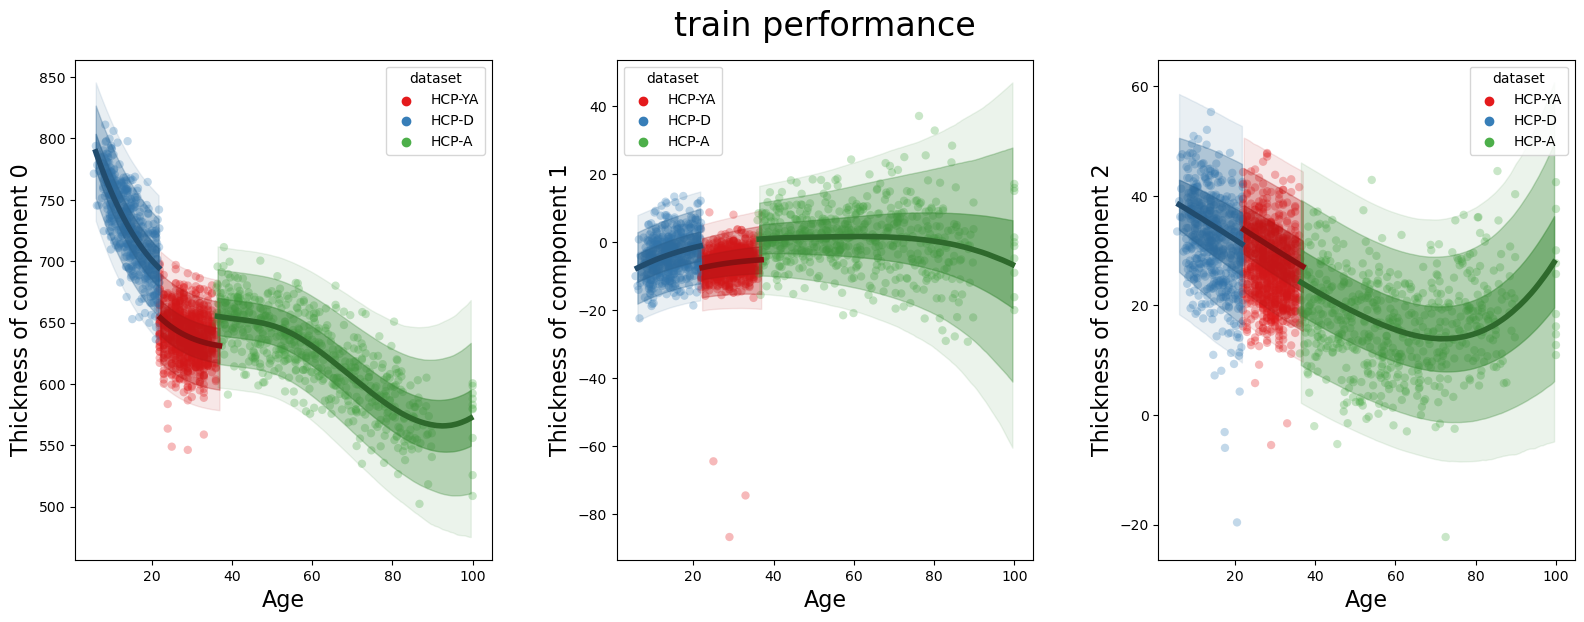

In [691]:
%%time

# sample from required columns
sample_df = train_df.copy()

# Data preperation
age = sample_df['age'].values
age_standardized = (age - age.mean()) / age.std()
site_idxs, sites = pd.factorize(sample_df['site'])
sex_idxs, sexes = pd.factorize(sample_df['sex'])

# Splines to model nonlinear age effects on thickness
# number of spline nuts (could be tuned)
num_knots = 3
knot_list = np.quantile(age_standardized, np.linspace(0, 1, num_knots))
# create b spline basis for regression using patsy
# B_spline_age = patsy.dmatrix(
#     "bs(age_standardized, knots=knots, degree=3, include_intercept=True) - 1",
#     {"age_standardized": age_standardized, "knots": knot_list[1:-1]},
# )
B_spline_age = patsy.build_design_matrices(
    [fixed_B_spline_age.design_info],
    {"xi": age, "knots": patsy_knots}
)[0]

coords = {
    "site": sites,
    "sex": sexes,
    "splines": np.arange(B_spline_age.shape[1]),
    "obs_id": np.arange(len(site_idxs)),
}


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for c in range(3):
    ax = axes[c]
    kernel_name = f'thickness_connectome_pc_{c}'
    thickness = sample_df[kernel_name].values
    thickness_mean = thickness.mean()
    thickness_std = thickness.std()
    thickness_standardized = (thickness - thickness_mean) / thickness_std
    
    sns.scatterplot(
        data=sample_df,
        x='age',
        y=kernel_name,
        ax=ax,
        linewidth=0,
        hue='dataset',
        palette="Set1",
        alpha = 0.3,
    )

    ax.set_xlabel('Age', fontsize=16)
    ax.set_ylabel(f'Thickness of component {c}', fontsize=16)

    for idx in np.unique(site_idxs):
        xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
        selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
        # post = advi_model_idata.posterior
        advi_model_idata = az.from_netcdf(f'{main_dir}/data/models/pymc/connectome_rw_kernel/{kernel_name}_pymc_advi.nc')
        post = advi_model_idata.posterior

        # prediction_B_spline_age = patsy.dmatrix(
        #     "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
        #     {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
        # )
        prediction_B_spline_age = patsy.build_design_matrices(
            [fixed_B_spline_age.design_info],
            {"xi": xi, "knots": patsy_knots}
        )[0]

        y_ppc_mu = (
            post['intercept_sex'].stack(sample=("chain", "draw"))[0].data +
            post['intercept_site'].stack(sample=("chain", "draw"))[idx].data +
            np.dot(
                prediction_B_spline_age,
                post['w_age'].stack(sample=("chain", "draw"))
            )
        )
        y_ppc_mu_mean = y_ppc_mu.mean(1)

        y_ppc_sigma = (
            post['error_sex'].stack(sample=("chain", "draw"))[0].data +
            post['error_site'].stack(sample=("chain", "draw"))[idx].data +
            np.dot(
                prediction_B_spline_age,
                post['w_error_age'].stack(sample=("chain", "draw"))
            )
        )
        y_ppc_sigma_mean = y_ppc_sigma.mean(1)

        # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data

        # need to ensure the correctness
        quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]

        thickness_quantiles = {
            q: (
                (
                    # y_ppc_mu_mean + stats.norm.ppf(q=q) * y_ppc_sigma_mean
                    np.quantile(((y_ppc_mu + stats.norm.ppf(q=q) * y_ppc_sigma)), q, 1)
                )  * thickness_std +
                thickness_mean
            ) for q in quantiles
        }

        # centile plot
        for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
            ax.fill_between(
                xi[selection],
                thickness_quantiles[q1][selection],
                thickness_quantiles[q2][selection],
                alpha=alpha,
                color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
            )

        ax.plot(
            xi[selection],
            thickness_quantiles[0.5][selection],
            c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
            lw=4,
        )

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.)
plt.suptitle("train performance", y=1.1, fontsize=24)

/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/arviz/data/inference_data.py:146: UserWarning: training group is not defined in the InferenceData scheme
  warnings.warn(
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/arviz/data/inference_data.py:146: UserWarning: training group is not defined in the InferenceData scheme
  warnings.warn(


CPU times: user 20.9 s, sys: 21 s, total: 41.8 s
Wall time: 2.28 s


Text(0.5, 1.1, 'test performance')

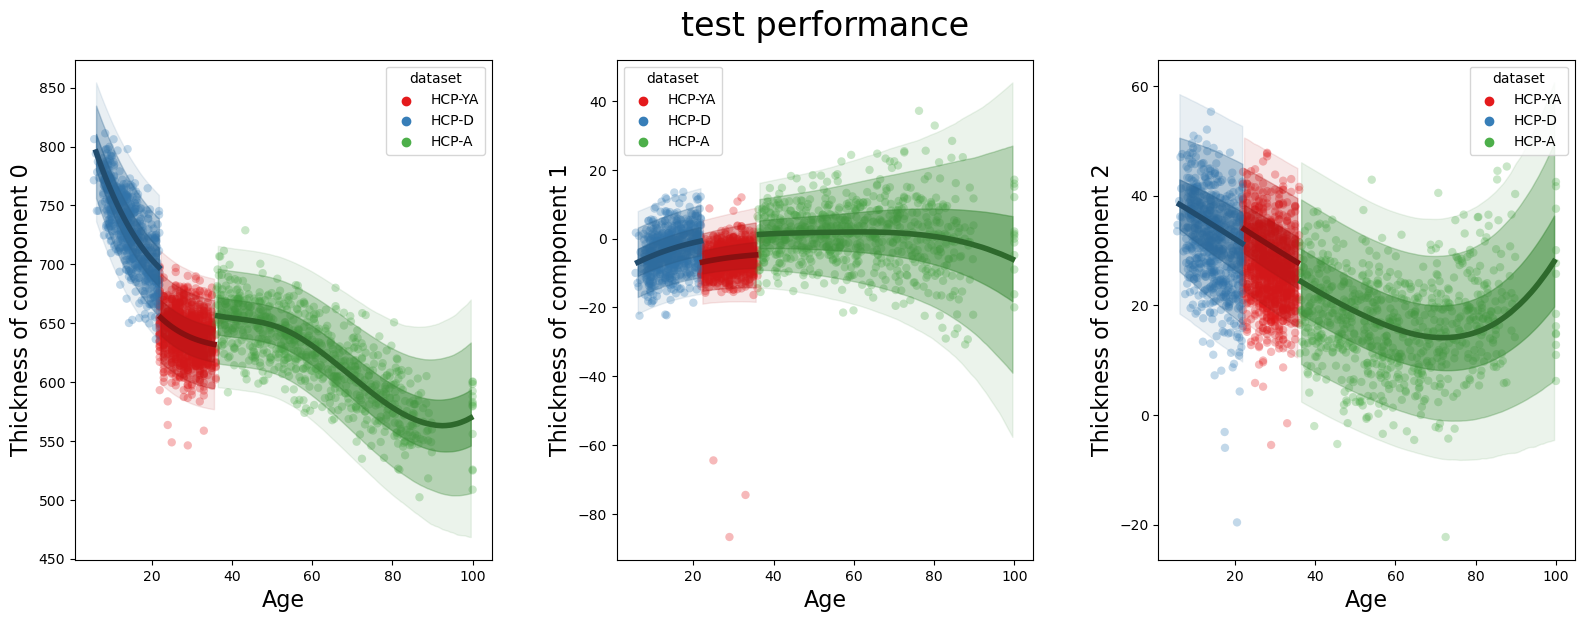

In [692]:
%%time

# sample from required columns
sample_df = test_df.copy()

# Data preperation
age = sample_df['age'].values
age_standardized = (age - age.mean()) / age.std()
site_idxs, sites = pd.factorize(sample_df['site'])
sex_idxs, sexes = pd.factorize(sample_df['sex'])

# Splines to model nonlinear age effects on thickness
# number of spline nuts (could be tuned)
num_knots = 3
knot_list = np.quantile(age_standardized, np.linspace(0, 1, num_knots))
# create b spline basis for regression using patsy
# B_spline_age = patsy.dmatrix(
#     "bs(age_standardized, knots=knots, degree=3, include_intercept=True) - 1",
#     {"age_standardized": age_standardized, "knots": knot_list[1:-1]},
# )
B_spline_age = patsy.build_design_matrices(
    [fixed_B_spline_age.design_info],
    {"xi": age, "knots": patsy_knots}
)[0]

coords = {
    "site": sites,
    "sex": sexes,
    "splines": np.arange(B_spline_age.shape[1]),
    "obs_id": np.arange(len(site_idxs)),
}


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for c in range(3):
    ax = axes[c]
    kernel_name = f'thickness_connectome_pc_{c}'
    thickness = sample_df[kernel_name].values
    thickness_mean = thickness.mean()
    thickness_std = thickness.std()
    thickness_standardized = (thickness - thickness_mean) / thickness_std
    
    sns.scatterplot(
        data=demography_extended_df,
        x='age',
        y=kernel_name,
        ax=ax,
        linewidth=0,
        hue='dataset',
        palette="Set1",
        alpha = 0.3,
    )

    ax.set_xlabel('Age', fontsize=16)
    ax.set_ylabel(f'Thickness of component {c}', fontsize=16)

    for idx in np.unique(site_idxs):
        xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
        selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
        # post = advi_model_idata.posterior
        advi_model_idata = az.from_netcdf(f'{main_dir}/data/models/pymc/connectome_rw_kernel/{kernel_name}_pymc_advi.nc')
        post = advi_model_idata.posterior

        # prediction_B_spline_age = patsy.dmatrix(
        #     "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
        #     {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
        # )
        prediction_B_spline_age = patsy.build_design_matrices(
            [fixed_B_spline_age.design_info],
            {"xi": xi, "knots": patsy_knots}
        )[0]

        y_ppc_mu = (
            post['intercept_sex'].stack(sample=("chain", "draw"))[0].data +
            post['intercept_site'].stack(sample=("chain", "draw"))[idx].data +
            np.dot(
                prediction_B_spline_age,
                post['w_age'].stack(sample=("chain", "draw"))
            )
        )
        y_ppc_mu_mean = y_ppc_mu.mean(1)

        y_ppc_sigma = (
            post['error_sex'].stack(sample=("chain", "draw"))[0].data +
            post['error_site'].stack(sample=("chain", "draw"))[idx].data +
            np.dot(
                prediction_B_spline_age,
                post['w_error_age'].stack(sample=("chain", "draw"))
            )
        )
        y_ppc_sigma_mean = y_ppc_sigma.mean(1)

        # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data

        # need to ensure the correctness
        quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]

        thickness_quantiles = {
            q: (
                (
                    # y_ppc_mu_mean + stats.norm.ppf(q=q) * y_ppc_sigma_mean
                    np.quantile(((y_ppc_mu + stats.norm.ppf(q=q) * y_ppc_sigma)), q, 1)
                )  * thickness_std +
                thickness_mean
            ) for q in quantiles
        }

        # centile plot
        for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
            ax.fill_between(
                xi[selection],
                thickness_quantiles[q1][selection],
                thickness_quantiles[q2][selection],
                alpha=alpha,
                color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
            )

        ax.plot(
            xi[selection],
            thickness_quantiles[0.5][selection],
            c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
            lw=4,
        )

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.)
plt.suptitle("test performance", y=1.1, fontsize=24)

/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/arviz/data/inference_data.py:146: UserWarning: training group is not defined in the InferenceData scheme
  warnings.warn(
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/arviz/data/inference_data.py:146: UserWarning: training group is not defined in the InferenceData scheme
  warnings.warn(
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/arviz/data/inference_data.py:146: UserWarning: training group is not defined in the InferenceData scheme
  warnings.warn(


CPU times: user 22.4 s, sys: 21.5 s, total: 44 s
Wall time: 3.46 s


Text(0.5, 1.1, 'train performance')

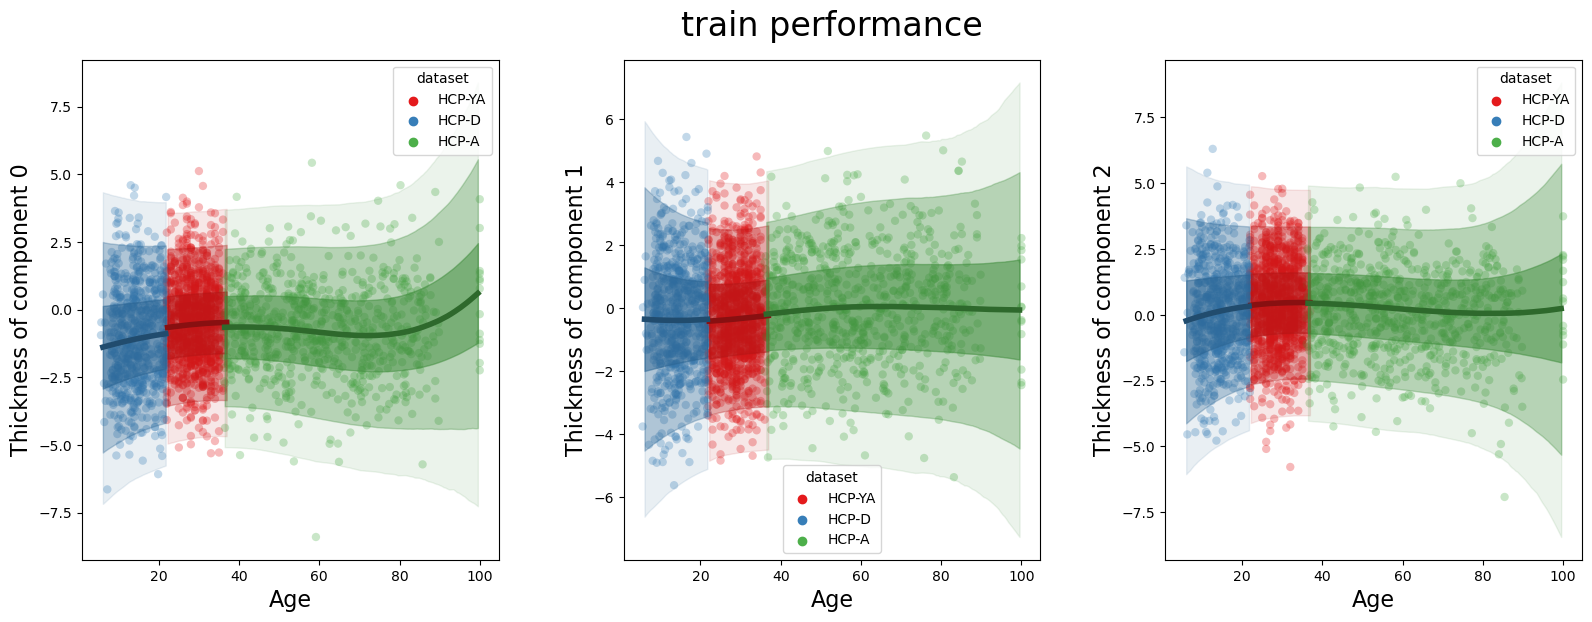

In [693]:
%%time

# sample from required columns
sample_df = train_df.copy()

# Data preperation
age = sample_df['age'].values
age_standardized = (age - age.mean()) / age.std()
site_idxs, sites = pd.factorize(sample_df['site'])
sex_idxs, sexes = pd.factorize(sample_df['sex'])

# Splines to model nonlinear age effects on thickness
# number of spline nuts (could be tuned)
num_knots = 3
knot_list = np.quantile(age_standardized, np.linspace(0, 1, num_knots))
# create b spline basis for regression using patsy
# B_spline_age = patsy.dmatrix(
#     "bs(age_standardized, knots=knots, degree=3, include_intercept=True) - 1",
#     {"age_standardized": age_standardized, "knots": knot_list[1:-1]},
# )
B_spline_age = patsy.build_design_matrices(
    [fixed_B_spline_age.design_info],
    {"xi": age, "knots": patsy_knots}
)[0]

coords = {
    "site": sites,
    "sex": sexes,
    "splines": np.arange(B_spline_age.shape[1]),
    "obs_id": np.arange(len(site_idxs)),
}


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for c in range(3):
    ax = axes[c]
    kernel_name = f'thickness_connectome_pc_{1000 + c}'
    thickness = sample_df[kernel_name].values
    thickness_mean = thickness.mean()
    thickness_std = thickness.std()
    thickness_standardized = (thickness - thickness_mean) / thickness_std
    
    sns.scatterplot(
        data=demography_extended_df,
        x='age',
        y=kernel_name,
        ax=ax,
        linewidth=0,
        hue='dataset',
        palette="Set1",
        alpha = 0.3,
    )

    ax.set_xlabel('Age', fontsize=16)
    ax.set_ylabel(f'Thickness of component {c}', fontsize=16)

    for idx in np.unique(site_idxs):
        xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
        selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
        # post = advi_model_idata.posterior
        advi_model_idata = az.from_netcdf(f'{main_dir}/data/models/pymc/connectome_rw_kernel/{kernel_name}_pymc_advi.nc')
        post = advi_model_idata.posterior

        # prediction_B_spline_age = patsy.dmatrix(
        #     "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
        #     {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
        # )
        prediction_B_spline_age = patsy.build_design_matrices(
            [fixed_B_spline_age.design_info],
            {"xi": xi, "knots": patsy_knots}
        )[0]

        y_ppc_mu = (
            post['intercept_sex'].stack(sample=("chain", "draw"))[0].data +
            post['intercept_site'].stack(sample=("chain", "draw"))[idx].data +
            np.dot(
                prediction_B_spline_age,
                post['w_age'].stack(sample=("chain", "draw"))
            )
        )
        y_ppc_mu_mean = y_ppc_mu.mean(1)

        y_ppc_sigma = (
            post['error_sex'].stack(sample=("chain", "draw"))[0].data +
            post['error_site'].stack(sample=("chain", "draw"))[idx].data +
            np.dot(
                prediction_B_spline_age,
                post['w_error_age'].stack(sample=("chain", "draw"))
            )
        )
        y_ppc_sigma_mean = y_ppc_sigma.mean(1)

        # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data

        # need to ensure the correctness
        quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]

        thickness_quantiles = {
            q: (
                (
                    # y_ppc_mu_mean + stats.norm.ppf(q=q) * y_ppc_sigma_mean
                    np.quantile(((y_ppc_mu + stats.norm.ppf(q=q) * y_ppc_sigma)), q, 1)
                )  * thickness_std +
                thickness_mean
            ) for q in quantiles
        }

        # centile plot
        for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
            ax.fill_between(
                xi[selection],
                thickness_quantiles[q1][selection],
                thickness_quantiles[q2][selection],
                alpha=alpha,
                color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
            )

        ax.plot(
            xi[selection],
            thickness_quantiles[0.5][selection],
            c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
            lw=4,
        )

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.)
plt.suptitle("train performance", y=1.1, fontsize=24)

/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/arviz/data/inference_data.py:146: UserWarning: training group is not defined in the InferenceData scheme
  warnings.warn(
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/arviz/data/inference_data.py:146: UserWarning: training group is not defined in the InferenceData scheme
  warnings.warn(
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/arviz/data/inference_data.py:146: UserWarning: training group is not defined in the InferenceData scheme
  warnings.warn(


CPU times: user 21.8 s, sys: 20.8 s, total: 42.6 s
Wall time: 2.26 s


Text(0.5, 1.1, 'train performance')

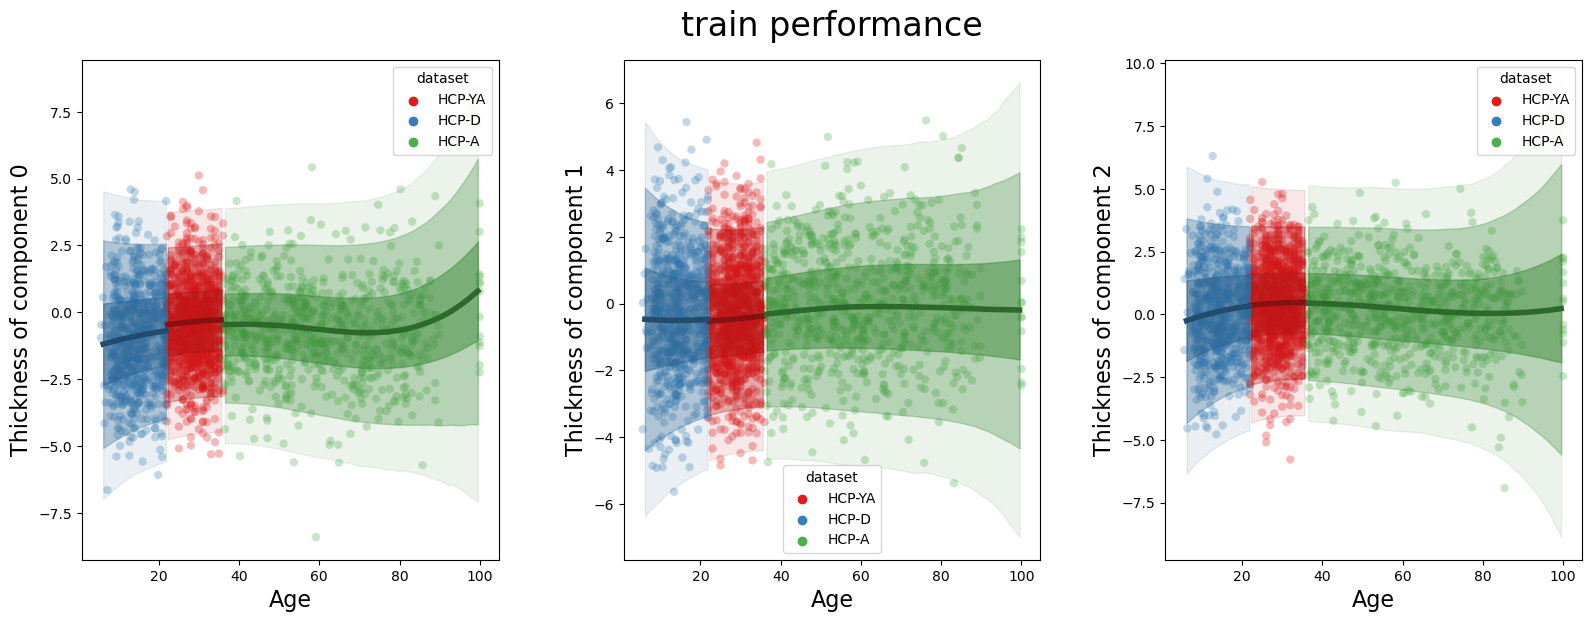

In [694]:
%%time

# sample from required columns
sample_df = test_df.copy()

# Data preperation
age = sample_df['age'].values
age_standardized = (age - age.mean()) / age.std()
site_idxs, sites = pd.factorize(sample_df['site'])
sex_idxs, sexes = pd.factorize(sample_df['sex'])

# Splines to model nonlinear age effects on thickness
# number of spline nuts (could be tuned)
num_knots = 3
knot_list = np.quantile(age_standardized, np.linspace(0, 1, num_knots))
# create b spline basis for regression using patsy
# B_spline_age = patsy.dmatrix(
#     "bs(age_standardized, knots=knots, degree=3, include_intercept=True) - 1",
#     {"age_standardized": age_standardized, "knots": knot_list[1:-1]},
# )
B_spline_age = patsy.build_design_matrices(
    [fixed_B_spline_age.design_info],
    {"xi": age, "knots": patsy_knots}
)[0]

coords = {
    "site": sites,
    "sex": sexes,
    "splines": np.arange(B_spline_age.shape[1]),
    "obs_id": np.arange(len(site_idxs)),
}


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for c in range(3):
    ax = axes[c]
    kernel_name = f'thickness_connectome_pc_{1000 + c}'
    thickness = sample_df[kernel_name].values
    thickness_mean = thickness.mean()
    thickness_std = thickness.std()
    thickness_standardized = (thickness - thickness_mean) / thickness_std
    
    sns.scatterplot(
        data=demography_extended_df,
        x='age',
        y=kernel_name,
        ax=ax,
        linewidth=0,
        hue='dataset',
        palette="Set1",
        alpha = 0.3,
    )

    ax.set_xlabel('Age', fontsize=16)
    ax.set_ylabel(f'Thickness of component {c}', fontsize=16)

    for idx in np.unique(site_idxs):
        xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
        selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
        # post = advi_model_idata.posterior
        advi_model_idata = az.from_netcdf(f'{main_dir}/data/models/pymc/connectome_rw_kernel/{kernel_name}_pymc_advi.nc')
        post = advi_model_idata.posterior

        # prediction_B_spline_age = patsy.dmatrix(
        #     "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
        #     {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
        # )
        prediction_B_spline_age = patsy.build_design_matrices(
            [fixed_B_spline_age.design_info],
            {"xi": xi, "knots": patsy_knots}
        )[0]

        y_ppc_mu = (
            post['intercept_sex'].stack(sample=("chain", "draw"))[0].data +
            post['intercept_site'].stack(sample=("chain", "draw"))[idx].data +
            np.dot(
                prediction_B_spline_age,
                post['w_age'].stack(sample=("chain", "draw"))
            )
        )
        y_ppc_mu_mean = y_ppc_mu.mean(1)

        y_ppc_sigma = (
            post['error_sex'].stack(sample=("chain", "draw"))[0].data +
            post['error_site'].stack(sample=("chain", "draw"))[idx].data +
            np.dot(
                prediction_B_spline_age,
                post['w_error_age'].stack(sample=("chain", "draw"))
            )
        )
        y_ppc_sigma_mean = y_ppc_sigma.mean(1)

        # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data

        # need to ensure the correctness
        quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]

        thickness_quantiles = {
            q: (
                (
                    # y_ppc_mu_mean + stats.norm.ppf(q=q) * y_ppc_sigma_mean
                    np.quantile(((y_ppc_mu + stats.norm.ppf(q=q) * y_ppc_sigma)), q, 1)
                )  * thickness_std +
                thickness_mean
            ) for q in quantiles
        }

        # centile plot
        for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
            ax.fill_between(
                xi[selection],
                thickness_quantiles[q1][selection],
                thickness_quantiles[q2][selection],
                alpha=alpha,
                color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
            )

        ax.plot(
            xi[selection],
            thickness_quantiles[0.5][selection],
            c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
            lw=4,
        )

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.)
plt.suptitle("train performance", y=1.1, fontsize=24)

After modelling the distributions of kernel loadings separately, the next step is to model covariances accurately.

## Select largest covariance pairs

---

The largest pairs of kernels in terms of correlation could be used to model a sparse covariance structure.

In [40]:
# correlations matrix
correlations = np.corrcoef(all_thickness_data_encoded.T)
correlations.shape


(11001, 11001)

In [41]:
# Estimate correlation matrix over different subsets of sample
corr_dict = {}

for siteCode in pd.unique(demography_df['siteCode']):
    for sex in pd.unique(demography_df['sex']):
        subset_site = (demography_df['siteCode'] == siteCode)
        subset_sex = (demography_df['sex'] == sex)
        corr_dict[f'siteCode-{siteCode}'] = np.corrcoef(all_thickness_data_encoded[subset_site].T)
        corr_dict[f'sex-{sex}'] = np.corrcoef(all_thickness_data_encoded[subset_sex].T)
        corr_dict[f'siteCode-{siteCode}&sex-{sex}'] = np.corrcoef(all_thickness_data_encoded[subset_site & subset_sex].T)

corr_max_site_sex = np.maximum.reduce([np.abs(corr_dict[x]) for x in corr_dict.keys()])
corr_max_site_sex.shape


(11001, 11001)

In [ ]:
# Estimate correlation matrix over different random subsets
# rand_corr_dict = {}
corr_max_rand = np.zeros(corr_max_site_sex.shape)

np.random.seed(0)
samples = 100
proportion = 0.2
random_samples = np.random.choice([True, False], size=(samples, demography_df.shape[0]), p=[proportion, 1 - proportion])
for i in range(samples):
    subset_mask = random_samples[i]
    # rand_corr_dict[f'random-{i}'] = np.corrcoef(all_thickness_data_encoded[subset_mask].T)
    corr_max_rand = np.maximum.reduce([
        corr_max_rand,
        np.corrcoef(all_thickness_data_encoded[subset_mask].T),
    ])

# corr_max_rand = np.maximum.reduce([np.abs(rand_corr_dict[x]) for x in rand_corr_dict.keys()])
# corr_max_rand.shape


In [102]:
# corr_max_all = np.maximum.reduce([np.abs(correlations), corr_max_site_sex, corr_max_rand])
corr_max_all = np.maximum.reduce([np.abs(correlations), corr_max_site_sex])
corr_max_all.shape


(11001, 11001)

Text(0.5, 1.0, 'Absolute correlation histogram')

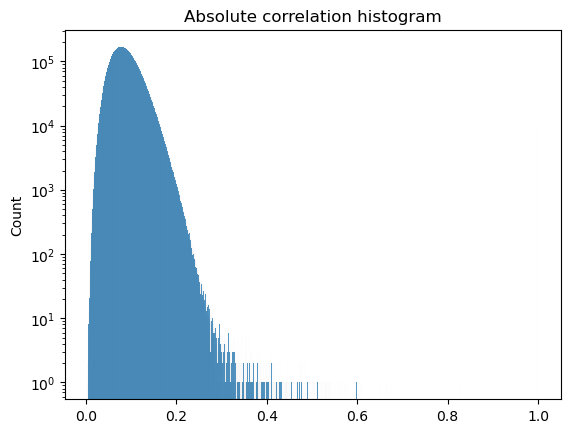

In [103]:
sns.histplot(corr_max_all[np.triu_indices_from(corr_max_all)], log_scale=(False, True))
plt.title('Absolute correlation histogram')


Text(0.5, 1.0, 'Absolute correlation histogram')

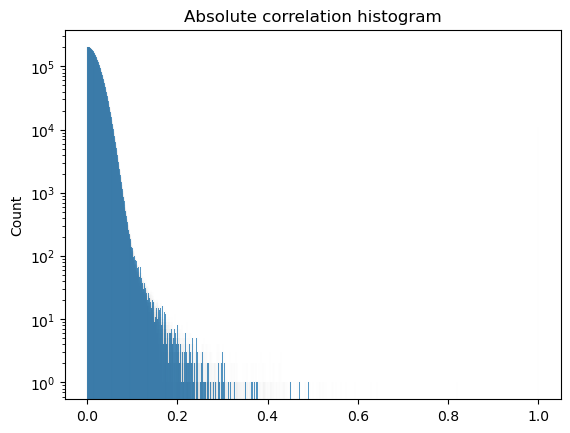

In [43]:
sns.histplot(np.abs(correlations)[np.triu_indices_from(correlations)], log_scale=(False, True))
plt.title('Absolute correlation histogram')


In [104]:
(corr_max_all[np.triu_indices_from(corr_max_all, 1)] > 0.3).sum()


878

In [105]:
(corr_max_all[np.triu_indices_from(corr_max_all, 1)] > 0.25).sum()


4261

In [106]:
(corr_max_all[np.triu_indices_from(corr_max_all, 1)] > 0.2).sum()


97196

In [45]:
(np.abs(correlations)[np.triu_indices_from(correlations, 1)] > 0.3).sum()


378

In [46]:
(np.abs(correlations)[np.triu_indices_from(correlations, 1)] > 0.2).sum()


2069

In [109]:
np.multiply(
    (corr_max_all[np.triu_indices_from(corr_max_all, 1)] > 0.25),
    (np.abs(correlations)[np.triu_indices_from(correlations, 1)] > 0.2)
).sum()

1345

(11000, 0.1)

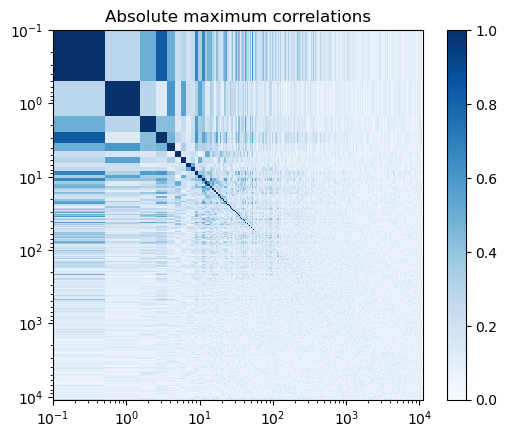

In [110]:
fig, ax = plt.subplots()

shw = ax.imshow(
    corr_max_all,
    # np.multiply(corr_max_site_sex, corr_max_site_sex>0.3),
    cmap=plt.cm.Blues, vmin=0, vmax=1)
bar = plt.colorbar(shw)
ax.set_title('Absolute maximum correlations')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.1, 11000)
ax.set_ylim(11000, 0.1)


(11000, 0.1)

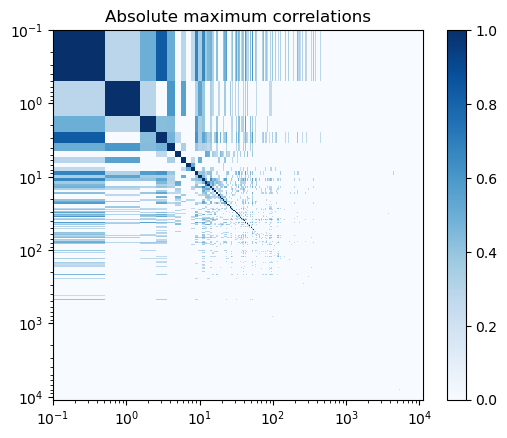

In [111]:
fig, ax = plt.subplots()

shw = ax.imshow(
    # corr_max_site_sex,
    np.multiply(corr_max_all, corr_max_all>0.25),
    cmap=plt.cm.Blues, vmin=0, vmax=1)
bar = plt.colorbar(shw)
ax.set_title('Absolute maximum correlations')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.1, 11000)
ax.set_ylim(11000, 0.1)


(11000, 0.1)

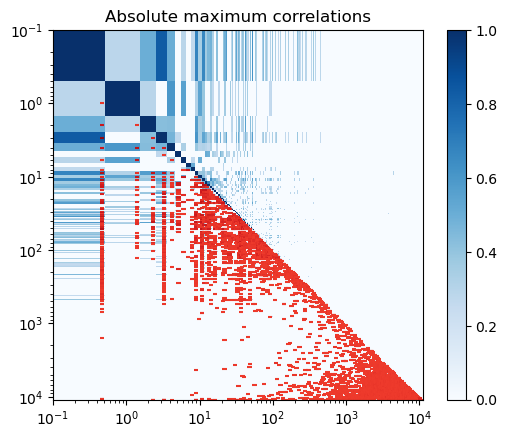

In [112]:
rows, cols = np.where(corr_max_all>0.25)
rows_lim = rows[rows < cols]
cols_lim = cols[rows < cols]

fig, ax = plt.subplots()

shw = ax.imshow(
    # corr_max_site_sex,
    np.multiply(corr_max_all, corr_max_all>0.25),
    cmap=plt.cm.Blues, vmin=0, vmax=1)
bar = plt.colorbar(shw)

sct = ax.scatter(
    rows_lim + 0.5, cols_lim, s=10,
    c=corr_max_site_sex[rows_lim, cols_lim],
    cmap=plt.cm.Reds, vmin=-1, vmax=1, marker=0
)

ax.set_title('Absolute maximum correlations')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.1, 11000)
ax.set_ylim(11000, 0.1)


(10000.0, 0.0)

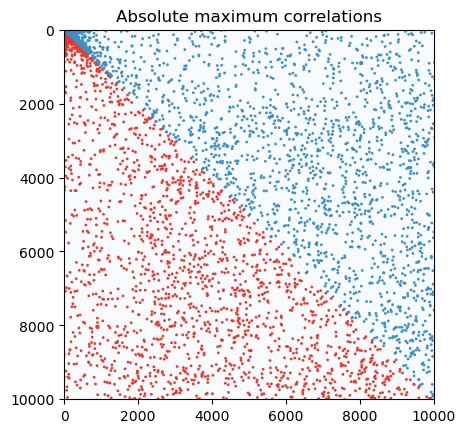

In [116]:
rows, cols = np.where(corr_max_all>0.25)
rows_lim = rows[rows < cols]
cols_lim = cols[rows < cols]

fig, ax = plt.subplots()

shw = ax.imshow(
    # corr_max_site_sex,
    np.multiply(corr_max_all, corr_max_all>0.25),
    cmap=plt.cm.Blues, vmin=0, vmax=1)
# bar = plt.colorbar(shw)

sct = ax.scatter(
    rows_lim, cols_lim, s=1,
    c=corr_max_site_sex[rows_lim, cols_lim],
    cmap=plt.cm.Reds, vmin=-1, vmax=1,
)
sct = ax.scatter(
    cols_lim, rows_lim, s=1,
    c=corr_max_site_sex[rows_lim, cols_lim],
    cmap=plt.cm.Blues, vmin=-1, vmax=1,
)

ax.set_title('Absolute maximum correlations')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(0., 10000)
ax.set_ylim(10000, 0.)


(2000.0, 0.0)

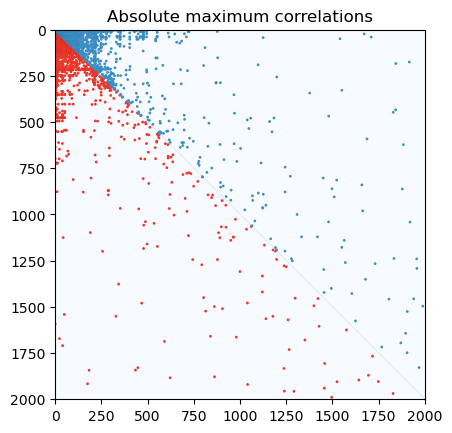

In [117]:
rows, cols = np.where(corr_max_all>0.25)
rows_lim = rows[rows < cols]
cols_lim = cols[rows < cols]

fig, ax = plt.subplots()

shw = ax.imshow(
    # corr_max_site_sex,
    np.multiply(corr_max_all, corr_max_all>0.25),
    cmap=plt.cm.Blues, vmin=0, vmax=1)
# bar = plt.colorbar(shw)

sct = ax.scatter(
    rows_lim, cols_lim, s=1,
    c=corr_max_site_sex[rows_lim, cols_lim],
    cmap=plt.cm.Reds, vmin=-1, vmax=1,
)
sct = ax.scatter(
    cols_lim, rows_lim, s=1,
    c=corr_max_site_sex[rows_lim, cols_lim],
    cmap=plt.cm.Blues, vmin=-1, vmax=1,
)

ax.set_title('Absolute maximum correlations')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(0., 2000)
ax.set_ylim(2000, 0.)


(500.0, 0.0)

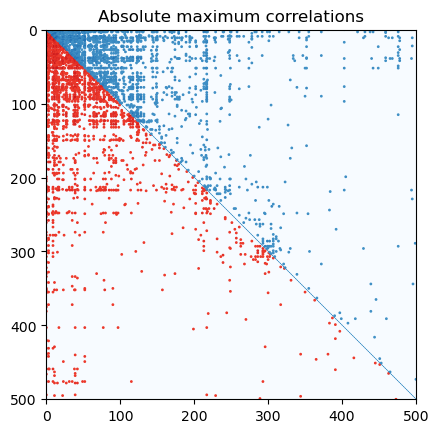

In [118]:
rows, cols = np.where(corr_max_all>0.25)
rows_lim = rows[rows < cols]
cols_lim = cols[rows < cols]

fig, ax = plt.subplots()

shw = ax.imshow(
    # corr_max_site_sex,
    np.multiply(corr_max_all, corr_max_all>0.25),
    cmap=plt.cm.Blues, vmin=0, vmax=1)
# bar = plt.colorbar(shw)

sct = ax.scatter(
    rows_lim, cols_lim, s=1,
    c=corr_max_site_sex[rows_lim, cols_lim],
    cmap=plt.cm.Reds, vmin=-1, vmax=1,
)
sct = ax.scatter(
    cols_lim, rows_lim, s=1,
    c=corr_max_site_sex[rows_lim, cols_lim],
    cmap=plt.cm.Blues, vmin=-1, vmax=1,
)

ax.set_title('Absolute maximum correlations')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(0., 500)
ax.set_ylim(500, 0.)


(100.0, 0.0)

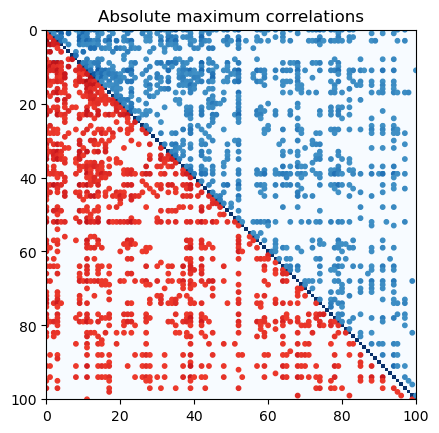

In [120]:
rows, cols = np.where(corr_max_all>0.25)
rows_lim = rows[rows < cols]
cols_lim = cols[rows < cols]

fig, ax = plt.subplots()

shw = ax.imshow(
    # corr_max_site_sex,
    np.multiply(corr_max_all, corr_max_all>0.25),
    cmap=plt.cm.Blues, vmin=0, vmax=1)
# bar = plt.colorbar(shw)

sct = ax.scatter(
    rows_lim, cols_lim, s=10,
    c=corr_max_site_sex[rows_lim, cols_lim],
    cmap=plt.cm.Reds, vmin=-1, vmax=1,
)
sct = ax.scatter(
    cols_lim, rows_lim, s=10,
    c=corr_max_site_sex[rows_lim, cols_lim],
    cmap=plt.cm.Blues, vmin=-1, vmax=1,
)

ax.set_title('Absolute maximum correlations')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(0., 100)
ax.set_ylim(100, 0.)


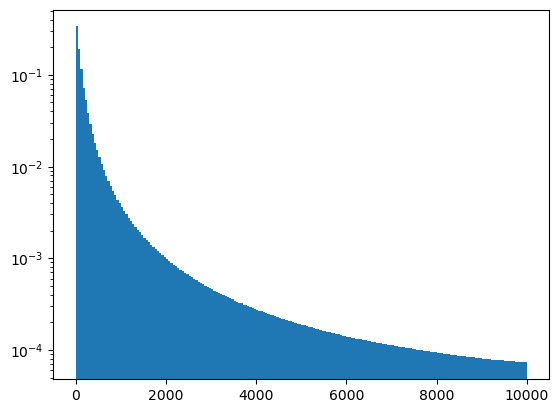

In [149]:
fig, ax = plt.subplots()

counts, bins = np.histogram(np.maximum.reduce([rows_lim, cols_lim]), range=(0, 10000), bins=200)

ax.bar((bins[1:]+bins[:-1])/2, np.cumsum(2 * counts)/(np.power(bins[1:], 2) - bins[1:]), width=bins[1]-bins[0],)

# ax.set_xscale('log')
ax.set_yscale('log')




In [150]:
rows, cols = np.where(corr_max_all>0.25)
rows_lim = rows[rows < cols]
cols_lim = cols[rows < cols]


In [199]:
selected_pairs = np.array([rows_lim, cols_lim]).T

write_np(corr_max_all, ensure_dir(f'{main_dir}/data/models/pymc/connectome_rw_kernel_rho/corr_max_all.npy'))
write_np(selected_pairs, ensure_dir(f'{main_dir}/data/models/pymc/connectome_rw_kernel_rho/selected_pairs_rho.npy'))


In [202]:
selected_pairs = load_np(f'{main_dir}/data/models/pymc/connectome_rw_kernel_rho/selected_pairs_rho.npy')


## Fit normative model for covariance pairs

---

For every selected pair, covariance will be fitted as implemented in 3.2.3.

In [172]:
# # old code before fixing the spline expansion

# import aesara.tensor as at

# # random seed for reproducibility
# rng = np.random.default_rng(12345)

# def run_pymc_advi_covariance_on_kernel_pairs(kernel_name1, kernel_name2, multiplicity=1000, train_df=train_df):
#     stored_model_file = f'{main_dir}/data/models/pymc/connectome_rw_kernel_rho/{kernel_name1},{kernel_name2}_pymc_advi_rho.nc'
#     if file_exists(stored_model_file, path_name=''):
#         try:
#             advi_model_idata_cov = az.from_netcdf(stored_model_file)
#             if type(advi_model_idata_cov) == az.data.inference_data.InferenceData:
#                 return ((kernel_name1, kernel_name2), stored_model_file)
#             else:
#                 os.remove(stored_model_file)
#         except:
#             os.remove(stored_model_file)
            
    
#     # sample from required columns
#     sample_df = train_df[['age', 'site', 'sex', kernel_name1, kernel_name2]].copy()

#     # Data preperation
#     age = sample_df['age'].values
#     age_standardized = (age - age.mean()) / age.std()
#     thickness_v1 = sample_df[kernel_name1].values
#     thickness_v1_standardized = (thickness_v1 - thickness_v1.mean()) / thickness_v1.std()
#     thickness_v2 = sample_df[kernel_name2].values
#     thickness_v2_standardized = (thickness_v2 - thickness_v2.mean()) / thickness_v2.std()
#     thicknesses_standardized = np.concatenate([thickness_v1_standardized[:, np.newaxis], thickness_v2_standardized[:, np.newaxis]], axis=1)
#     site_idxs, sites = pd.factorize(sample_df['site'])
#     sex_idxs, sexes = pd.factorize(sample_df['sex'])

#     # multiple weights from the same pair
#     age_standardized_mult = np.repeat(age_standardized[np.newaxis,:], multiplicity, axis=0).reshape(-1)
#     sex_idxs_mult = np.repeat(sex_idxs[np.newaxis,:], multiplicity, axis=0).reshape(-1)
#     site_idxs_mult = np.repeat(site_idxs[np.newaxis,:], multiplicity, axis=0).reshape(-1)

#     combination_weights_mult = []
#     combined_thicknesses_mult = []
#     for i in range(multiplicity):
#         # a weight to combine two variables with
#         combination_weights = (4*(np.random.uniform(size=thicknesses_standardized.shape) - 0.5))
#         combination_weights_mult.append(combination_weights)

#         # combine values
#         combined_thicknesses = np.multiply(thicknesses_standardized, combination_weights).sum(1)
#         combined_thicknesses_mult.append(combined_thicknesses)

#     combination_weights_mult = np.concatenate(combination_weights_mult)
#     combined_thicknesses_mult = np.concatenate(combined_thicknesses_mult)

#     # Splines to model nonlinear age effects on thickness
#     # number of spline nuts (could be tuned)
#     num_knots = 3
#     knot_list = np.quantile(age_standardized, np.linspace(0, 1, num_knots))
#     # create b spline basis for regression using patsy
#     B_spline_age = patsy.dmatrix(
#         "bs(age_standardized, knots=knots, degree=3, include_intercept=True) - 1",
#         {"age_standardized": age_standardized_mult, "knots": knot_list[1:-1]},
#     )

#     coords = {
#         "site": sites,
#         "sex": sexes,
#         "splines": np.arange(B_spline_age.shape[1]),
#         "obs_id": np.arange(len(site_idxs_mult)),
#     }

#     # loading previously fitted priors to use as constants
#     advi_model_idata_v1 = az.from_netcdf(f'{main_dir}/data/models/pymc/connectome_rw_kernel/{kernel_name1}_pymc_advi.nc')
#     advi_model_idata_v2 = az.from_netcdf(f'{main_dir}/data/models/pymc/connectome_rw_kernel/{kernel_name2}_pymc_advi.nc')

#     kernel_advi_model_cov = pm.Model(coords=coords)

#     # a nonlinear spline model (see https://www.pymc.io/projects/examples/en/latest/case_studies/spline.html)
#     with kernel_advi_model_cov:
#         # minibatch variables
#         age_standardized_t = pm.Minibatch(age_standardized_mult, 512,)
#         sex_idx_t = pm.Minibatch(sex_idxs_mult, 512)
#         site_idx_t = pm.Minibatch(site_idxs_mult, 512)
#         B_spline_age_t = pm.Minibatch(B_spline_age, 512)
#         combined_thicknesses_t = pm.Minibatch(combined_thicknesses_mult, 512)
#         combination_weights_t = pm.Minibatch(combination_weights_mult, 512)

#         # Hyperpriors for site groups (as if we have random group effects)
#         mu_intercept_site_rho = pm.Normal('mu_intercept_site_rho', mu=0, sigma=10)
#         sigma_intercept_site_rho = pm.HalfNormal("sigma_intercept_site_rho", sigma=10)
#         # sigma_error_site_cov = pm.HalfNormal("sigma_error_site_cov", sigma=10)


#         # Priors (for covariance/correlation)
#         # sex effects (similar to fixed sex effects (intercept only))
#         intercept_sex_rho = pm.Normal("intercept_sex_rho", mu=0, sigma=0.1, dims="sex")

#         # site effects (similar to random site effects (intercept only))
#         intercept_site_offset_rho = pm.Normal("intercept_site_offset_rho", mu=0, sigma=0.1, dims="site")
#         intercept_site_rho = pm.Deterministic("intercept_site_rho", mu_intercept_site_rho + intercept_site_offset_rho * sigma_intercept_site_rho, dims="site")

#         # age splines
#         w_age_rho = pm.Normal("w_age_rho", mu=0, sigma=0.1, size=B_spline_age.shape[1], dims="splines")

#         # Estimated covariance/correlation
#         # z_est = pm.Deterministic("z_est", intercept_sex_rho[sex_idx_t] + intercept_site_rho[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_rho.T), dims="obs_id")
#         z_est = intercept_sex_rho[sex_idx_t] + intercept_site_rho[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_rho.T)
#         # rho_est = pm.Deterministic("rho_est", 2 * pm.math.sigmoid(intercept_sex_rho[sex_idx_t] + intercept_site_rho[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_rho.T)) - 1)
#         # rho_est = pm.Deterministic("rho_est", 2 * pm.math.sigmoid(z_est) - 1)
#         rho_est = 2 * pm.math.sigmoid(z_est) - 1
    

#         # Priors (constant priors, already fitted in previous models)
#         # sex effects (similar to fixed sex effects (intercept only))
#         # intercept_sex = pm.Normal("intercept_sex", mu=0, sigma=10, dims="sex")
#         intercept_sex_v1 = pm.ConstantData("intercept_sex_v1", np.array(advi_model_idata_v1.posterior['intercept_sex'].stack(sample=("chain", "draw")).mean('sample')), dims="sex")
#         intercept_sex_v2 = pm.ConstantData("intercept_sex_v2", np.array(advi_model_idata_v2.posterior['intercept_sex'].stack(sample=("chain", "draw")).mean('sample')), dims="sex")
    
#         # site effects (similar to random site effects (intercept only))
#         #a_site = pm.Normal("a_site", mu=mu_a_site, sigma=sigma_a_site, dims="site")
#         # intercept_site_offset = pm.Normal("intercept_site_offset", mu=0, sigma=1, dims="site")
#         # intercept_site = pm.Deterministic("intercept_site", mu_intercept_site + intercept_site_offset * sigma_intercept_site, dims="site")
#         intercept_site_v1 = pm.ConstantData("intercept_site_v1", np.array(advi_model_idata_v1.posterior['intercept_site'].stack(sample=("chain", "draw")).mean('sample')), dims="site")
#         intercept_site_v2 = pm.ConstantData("intercept_site_v2", np.array(advi_model_idata_v2.posterior['intercept_site'].stack(sample=("chain", "draw")).mean('sample')), dims="site")

#         # age splines
#         # w_age = pm.Normal("w_age", mu=0, sigma=10, size=B_spline_age.shape[1], dims="splines")
#         w_age_v1 = pm.ConstantData("w_age_v1", np.array(advi_model_idata_v1.posterior['w_age'].stack(sample=("chain", "draw")).mean('sample')), dims="splines")
#         w_age_v2 = pm.ConstantData("w_age_v2", np.array(advi_model_idata_v2.posterior['w_age'].stack(sample=("chain", "draw")).mean('sample')), dims="splines")

#         # Estimated thickness
#         # thickness_est = pm.Deterministic("thickness_est", intercept_sex[sex_idx_t] + intercept_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_age.T))
#         # thickness_est_v1 = pm.Deterministic("thickness_est_v1", intercept_sex_v1[sex_idx_t] + intercept_site_v1[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_v1.T))
#         thickness_est_v1 = intercept_sex_v1[sex_idx_t] + intercept_site_v1[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_v1.T)
#         # thickness_est_v2 = pm.Deterministic("thickness_est_v2", intercept_sex_v2[sex_idx_t] + intercept_site_v2[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_v2.T))
#         thickness_est_v2 = intercept_sex_v2[sex_idx_t] + intercept_site_v2[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_v2.T)

#         # Model error
#         # nonlinear age error
#         # w_error_age = pm.HalfCauchy("w_error_age", beta=5, size=B_spline_age.shape[1], dims="splines")
#         w_error_age_v1 = pm.ConstantData("w_error_age_v1", np.array(advi_model_idata_v1.posterior['w_error_age'].stack(sample=("chain", "draw")).mean('sample')), dims="splines")
#         w_error_age_v2 = pm.ConstantData("w_error_age_v2", np.array(advi_model_idata_v2.posterior['w_error_age'].stack(sample=("chain", "draw")).mean('sample')), dims="splines")

#         # constant sex error
#         # error_sex = pm.HalfCauchy("error_sex", beta=5, dims="sex")
#         error_sex_v1 = pm.ConstantData("error_sex_v1", np.array(advi_model_idata_v1.posterior['error_sex'].stack(sample=("chain", "draw")).mean('sample')), dims="sex")
#         error_sex_v2 = pm.ConstantData("error_sex_v2", np.array(advi_model_idata_v2.posterior['error_sex'].stack(sample=("chain", "draw")).mean('sample')), dims="sex")

#         # random site error
#         # error_site_offset = pm.HalfCauchy("error_site_offset", beta=5, dims="site")
#         # error_site = pm.Deterministic("error_site", error_site_offset * sigma_error_site, dims="site")
#         error_site_v1 = pm.ConstantData("error_site_v1", np.array(advi_model_idata_v1.posterior['error_site'].stack(sample=("chain", "draw")).mean('sample')), dims="site")
#         error_site_v2 = pm.ConstantData("error_site_v2", np.array(advi_model_idata_v2.posterior['error_site'].stack(sample=("chain", "draw")).mean('sample')), dims="site")

#         # Error estimate
#         # thickness_error = pm.Deterministic("thickness_error", error_sex[sex_idx_t] + error_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age.T))
#         # thickness_error_v1 = pm.Deterministic("thickness_error_v1", error_sex_v1[sex_idx_t] + error_site_v1[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age_v1.T))
#         thickness_error_v1 = error_sex_v1[sex_idx_t] + error_site_v1[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age_v1.T)
#         # thickness_error_v2 = pm.Deterministic("thickness_error_v2", error_sex_v2[sex_idx_t] + error_site_v2[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age_v2.T))
#         thickness_error_v2 = error_sex_v2[sex_idx_t] + error_site_v2[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age_v2.T)

#         # Likelihood (sampling distribution) of observations
#         # Likelihood estimation from a bivariate normal with known mean and variance, but unknown covariance
#         # combined_mu = pm.Deterministic("combined_mu", pm.math.sum(at.math.mul(combination_weights_t, at.stacklists([thickness_est_v1, thickness_est_v2]).T), axis=1))
#         combined_mu = pm.math.sum(at.math.mul(combination_weights_t, at.stacklists([thickness_est_v1, thickness_est_v2]).T), axis=1)
#         # combined_sigma = pm.Deterministic("combined_sigma", at.math.mul(combination_weights_t, at.stacklists([thickness_error_v1, thickness_error_v2]).T))
#         combined_sigma = at.math.mul(combination_weights_t, at.stacklists([thickness_error_v1, thickness_error_v2]).T)
#         # combined_var = pm.Deterministic("combined_var", pm.math.sqrt(combined_sigma[:, 0]**2 + combined_sigma[:, 1]**2 + 2 * combined_sigma[:, 0] * combined_sigma[:, 1] * rho_est))
#         combined_var = pm.math.sqrt(combined_sigma[:, 0]**2 + combined_sigma[:, 1]**2 + 2 * combined_sigma[:, 0] * combined_sigma[:, 1] * rho_est)
    
#         # Likelihood estimation for covariance
#         likelihood = pm.Normal(
#             "likelihood",
#             mu=combined_mu,
#             sigma=combined_var,
#             observed=combined_thicknesses_t,
#             total_size=len(sample_df) * multiplicity,
#         )

#         # run ADVI with minibatch
#         error_approx_cov = pm.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)], random_seed=12345)
    
#         # sample from trace
#         advi_model_idata_cov = pm.sample_prior_predictive(random_seed=rng)
#         advi_model_idata_cov.extend(error_approx_cov.sample(2000, random_seed=rng))
#         pm.sample_posterior_predictive(advi_model_idata_cov, extend_inferencedata=True, random_seed=rng)
    
#     advi_model_idata_cov.to_netcdf(ensure_dir(stored_model_file))
#     return ((kernel_name1, kernel_name2), stored_model_file)

        

In [696]:
import aesara.tensor as at

# random seed for reproducibility
rng = np.random.default_rng(12345)

def run_pymc_advi_covariance_on_kernel_pairs(kernel_name1, kernel_name2, multiplicity=1000, train_df=train_df, fixed_B_spline_age=fixed_B_spline_age):
    stored_model_file = f'{main_dir}/data/models/pymc/connectome_rw_kernel_rho/{kernel_name1},{kernel_name2}_pymc_advi_rho.nc'
    if file_exists(stored_model_file, path_name=''):
        try:
            advi_model_idata_cov = az.from_netcdf(stored_model_file)
            if type(advi_model_idata_cov) == az.data.inference_data.InferenceData:
                return ((kernel_name1, kernel_name2), stored_model_file)
            else:
                os.remove(stored_model_file)
        except:
            os.remove(stored_model_file)
            
    
    # sample from required columns
    sample_df = train_df[['age', 'site', 'sex', kernel_name1, kernel_name2]].copy()

    # Data preperation
    age = sample_df['age'].values
    # age_standardized = (age - age.mean()) / age.std()
    thickness_v1 = sample_df[kernel_name1].values
    thickness_v1_standardized = (thickness_v1 - thickness_v1.mean()) / thickness_v1.std()
    thickness_v2 = sample_df[kernel_name2].values
    thickness_v2_standardized = (thickness_v2 - thickness_v2.mean()) / thickness_v2.std()
    thicknesses_standardized = np.concatenate([thickness_v1_standardized[:, np.newaxis], thickness_v2_standardized[:, np.newaxis]], axis=1)
    site_idxs, sites = pd.factorize(sample_df['site'])
    sex_idxs, sexes = pd.factorize(sample_df['sex'])

    # multiple weights from the same pair
    age_mult = np.repeat(age[np.newaxis,:], multiplicity, axis=0).reshape(-1)
    sex_idxs_mult = np.repeat(sex_idxs[np.newaxis,:], multiplicity, axis=0).reshape(-1)
    site_idxs_mult = np.repeat(site_idxs[np.newaxis,:], multiplicity, axis=0).reshape(-1)

    combination_weights_mult = []
    combined_thicknesses_mult = []
    for i in range(multiplicity):
        # a weight to combine two variables with
        combination_weights = (4*(np.random.uniform(size=thicknesses_standardized.shape) - 0.5))
        combination_weights_mult.append(combination_weights)

        # combine values
        combined_thicknesses = np.multiply(thicknesses_standardized, combination_weights).sum(1)
        combined_thicknesses_mult.append(combined_thicknesses)

    combination_weights_mult = np.concatenate(combination_weights_mult)
    combined_thicknesses_mult = np.concatenate(combined_thicknesses_mult)

    # Splines to model nonlinear age effects on thickness
    # Using the fixed B-Spline, no need to standardize age range
    B_spline_age = patsy.build_design_matrices(
        [fixed_B_spline_age.design_info],
        {"xi": age_mult, "knots": patsy_knots}
    )[0]

    coords = {
        "site": sites,
        "sex": sexes,
        "splines": np.arange(B_spline_age.shape[1]),
        "obs_id": np.arange(len(site_idxs_mult)),
    }

    # loading previously fitted priors to use as constants
    advi_model_idata_v1 = az.from_netcdf(f'{main_dir}/data/models/pymc/connectome_rw_kernel/{kernel_name1}_pymc_advi.nc')
    advi_model_idata_v2 = az.from_netcdf(f'{main_dir}/data/models/pymc/connectome_rw_kernel/{kernel_name2}_pymc_advi.nc')

    kernel_advi_model_cov = pm.Model(coords=coords)

    # a nonlinear spline model (see https://www.pymc.io/projects/examples/en/latest/case_studies/spline.html)
    with kernel_advi_model_cov:
        # minibatch variables
        # age_t = pm.Minibatch(age_mult, 512,)
        sex_idx_t = pm.Minibatch(sex_idxs_mult, 512)
        site_idx_t = pm.Minibatch(site_idxs_mult, 512)
        B_spline_age_t = pm.Minibatch(B_spline_age, 512)
        combined_thicknesses_t = pm.Minibatch(combined_thicknesses_mult, 512)
        combination_weights_t = pm.Minibatch(combination_weights_mult, 512)

        # Hyperpriors for site groups (as if we have random group effects)
        mu_intercept_site_rho = pm.Normal('mu_intercept_site_rho', mu=0, sigma=10)
        sigma_intercept_site_rho = pm.HalfNormal("sigma_intercept_site_rho", sigma=10)
        # sigma_error_site_cov = pm.HalfNormal("sigma_error_site_cov", sigma=10)


        # Priors (for covariance/correlation)
        # sex effects (similar to fixed sex effects (intercept only))
        intercept_sex_rho = pm.Normal("intercept_sex_rho", mu=0, sigma=0.1, dims="sex")

        # site effects (similar to random site effects (intercept only))
        intercept_site_offset_rho = pm.Normal("intercept_site_offset_rho", mu=0, sigma=0.1, dims="site")
        intercept_site_rho = pm.Deterministic("intercept_site_rho", mu_intercept_site_rho + intercept_site_offset_rho * sigma_intercept_site_rho, dims="site")

        # age splines
        w_age_rho = pm.Normal("w_age_rho", mu=0, sigma=0.1, size=B_spline_age.shape[1], dims="splines")

        # Estimated covariance/correlation
        # z_est = pm.Deterministic("z_est", intercept_sex_rho[sex_idx_t] + intercept_site_rho[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_rho.T), dims="obs_id")
        z_est = intercept_sex_rho[sex_idx_t] + intercept_site_rho[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_rho.T)
        # rho_est = pm.Deterministic("rho_est", 2 * pm.math.sigmoid(intercept_sex_rho[sex_idx_t] + intercept_site_rho[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_rho.T)) - 1)
        # rho_est = pm.Deterministic("rho_est", 2 * pm.math.sigmoid(z_est) - 1)
        rho_est = 2 * pm.math.sigmoid(z_est) - 1
    

        # Priors (constant priors, already fitted in previous models)
        # sex effects (similar to fixed sex effects (intercept only))
        # intercept_sex = pm.Normal("intercept_sex", mu=0, sigma=10, dims="sex")
        intercept_sex_v1 = pm.ConstantData("intercept_sex_v1", np.array(advi_model_idata_v1.posterior['intercept_sex'].stack(sample=("chain", "draw")).mean('sample')), dims="sex")
        intercept_sex_v2 = pm.ConstantData("intercept_sex_v2", np.array(advi_model_idata_v2.posterior['intercept_sex'].stack(sample=("chain", "draw")).mean('sample')), dims="sex")
    
        # site effects (similar to random site effects (intercept only))
        #a_site = pm.Normal("a_site", mu=mu_a_site, sigma=sigma_a_site, dims="site")
        # intercept_site_offset = pm.Normal("intercept_site_offset", mu=0, sigma=1, dims="site")
        # intercept_site = pm.Deterministic("intercept_site", mu_intercept_site + intercept_site_offset * sigma_intercept_site, dims="site")
        intercept_site_v1 = pm.ConstantData("intercept_site_v1", np.array(advi_model_idata_v1.posterior['intercept_site'].stack(sample=("chain", "draw")).mean('sample')), dims="site")
        intercept_site_v2 = pm.ConstantData("intercept_site_v2", np.array(advi_model_idata_v2.posterior['intercept_site'].stack(sample=("chain", "draw")).mean('sample')), dims="site")

        # age splines
        # w_age = pm.Normal("w_age", mu=0, sigma=10, size=B_spline_age.shape[1], dims="splines")
        w_age_v1 = pm.ConstantData("w_age_v1", np.array(advi_model_idata_v1.posterior['w_age'].stack(sample=("chain", "draw")).mean('sample')), dims="splines")
        w_age_v2 = pm.ConstantData("w_age_v2", np.array(advi_model_idata_v2.posterior['w_age'].stack(sample=("chain", "draw")).mean('sample')), dims="splines")

        # Estimated thickness
        # thickness_est = pm.Deterministic("thickness_est", intercept_sex[sex_idx_t] + intercept_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_age.T))
        # thickness_est_v1 = pm.Deterministic("thickness_est_v1", intercept_sex_v1[sex_idx_t] + intercept_site_v1[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_v1.T))
        thickness_est_v1 = intercept_sex_v1[sex_idx_t] + intercept_site_v1[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_v1.T)
        # thickness_est_v2 = pm.Deterministic("thickness_est_v2", intercept_sex_v2[sex_idx_t] + intercept_site_v2[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_v2.T))
        thickness_est_v2 = intercept_sex_v2[sex_idx_t] + intercept_site_v2[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_v2.T)

        # Model error
        # nonlinear age error
        # w_error_age = pm.HalfCauchy("w_error_age", beta=5, size=B_spline_age.shape[1], dims="splines")
        w_error_age_v1 = pm.ConstantData("w_error_age_v1", np.array(advi_model_idata_v1.posterior['w_error_age'].stack(sample=("chain", "draw")).mean('sample')), dims="splines")
        w_error_age_v2 = pm.ConstantData("w_error_age_v2", np.array(advi_model_idata_v2.posterior['w_error_age'].stack(sample=("chain", "draw")).mean('sample')), dims="splines")

        # constant sex error
        # error_sex = pm.HalfCauchy("error_sex", beta=5, dims="sex")
        error_sex_v1 = pm.ConstantData("error_sex_v1", np.array(advi_model_idata_v1.posterior['error_sex'].stack(sample=("chain", "draw")).mean('sample')), dims="sex")
        error_sex_v2 = pm.ConstantData("error_sex_v2", np.array(advi_model_idata_v2.posterior['error_sex'].stack(sample=("chain", "draw")).mean('sample')), dims="sex")

        # random site error
        # error_site_offset = pm.HalfCauchy("error_site_offset", beta=5, dims="site")
        # error_site = pm.Deterministic("error_site", error_site_offset * sigma_error_site, dims="site")
        error_site_v1 = pm.ConstantData("error_site_v1", np.array(advi_model_idata_v1.posterior['error_site'].stack(sample=("chain", "draw")).mean('sample')), dims="site")
        error_site_v2 = pm.ConstantData("error_site_v2", np.array(advi_model_idata_v2.posterior['error_site'].stack(sample=("chain", "draw")).mean('sample')), dims="site")

        # Error estimate
        # thickness_error = pm.Deterministic("thickness_error", error_sex[sex_idx_t] + error_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age.T))
        # thickness_error_v1 = pm.Deterministic("thickness_error_v1", error_sex_v1[sex_idx_t] + error_site_v1[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age_v1.T))
        thickness_error_v1 = error_sex_v1[sex_idx_t] + error_site_v1[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age_v1.T)
        # thickness_error_v2 = pm.Deterministic("thickness_error_v2", error_sex_v2[sex_idx_t] + error_site_v2[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age_v2.T))
        thickness_error_v2 = error_sex_v2[sex_idx_t] + error_site_v2[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age_v2.T)

        # Likelihood (sampling distribution) of observations
        # Likelihood estimation from a bivariate normal with known mean and variance, but unknown covariance
        # combined_mu = pm.Deterministic("combined_mu", pm.math.sum(at.math.mul(combination_weights_t, at.stacklists([thickness_est_v1, thickness_est_v2]).T), axis=1))
        combined_mu = pm.math.sum(at.math.mul(combination_weights_t, at.stacklists([thickness_est_v1, thickness_est_v2]).T), axis=1)
        # combined_sigma = pm.Deterministic("combined_sigma", at.math.mul(combination_weights_t, at.stacklists([thickness_error_v1, thickness_error_v2]).T))
        combined_sigma = at.math.mul(combination_weights_t, at.stacklists([thickness_error_v1, thickness_error_v2]).T)
        # combined_var = pm.Deterministic("combined_var", pm.math.sqrt(combined_sigma[:, 0]**2 + combined_sigma[:, 1]**2 + 2 * combined_sigma[:, 0] * combined_sigma[:, 1] * rho_est))
        combined_var = pm.math.sqrt(combined_sigma[:, 0]**2 + combined_sigma[:, 1]**2 + 2 * combined_sigma[:, 0] * combined_sigma[:, 1] * rho_est)
    
        # Likelihood estimation for covariance
        likelihood = pm.Normal(
            "likelihood",
            mu=combined_mu,
            sigma=combined_var,
            observed=combined_thicknesses_t,
            total_size=len(sample_df) * multiplicity,
        )

        # run ADVI with minibatch
        error_approx_cov = pm.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)], random_seed=12345)
    
        # sample from trace
        advi_model_idata_cov = pm.sample_prior_predictive(random_seed=rng)
        advi_model_idata_cov.extend(error_approx_cov.sample(2000, random_seed=rng))
        pm.sample_posterior_predictive(advi_model_idata_cov, extend_inferencedata=True, random_seed=rng)
    
    advi_model_idata_cov.to_netcdf(ensure_dir(stored_model_file))
    return ((kernel_name1, kernel_name2), stored_model_file)

        

In [697]:
kernel_name1, kernel_name2 = 'thickness_connectome_pc_0', 'thickness_connectome_pc_1'
run_pymc_advi_covariance_on_kernel_pairs(kernel_name1, kernel_name2)


/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/arviz/data/inference_data.py:146: UserWarning: training group is not defined in the InferenceData scheme
  warnings.warn(


Finished [100%]: Average Loss = 652.96
Sampling: [intercept_sex_rho, intercept_site_offset_rho, likelihood, mu_intercept_site_rho, sigma_intercept_site_rho, w_age_rho]
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation likelihood
  warnings.warn(f"Could not extract data from symbolic observation {obs}")
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation likelihood
  warnings.warn(f"Could not extract data from symbolic observation {obs}")
Sampling: [likelihood]


/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation likelihood
  warnings.warn(f"Could not extract data from symbolic observation {obs}")


(('thickness_connectome_pc_0', 'thickness_connectome_pc_1'),
 '/mountpoint/code/projects/normative_brain_charts/data/models/pymc/connectome_rw_kernel_rho/thickness_connectome_pc_0,thickness_connectome_pc_1_pymc_advi_rho.nc')

In [715]:
%%time
%%capture multiprocessing_log

import multiprocessing
import time

def mute():
    sys.stdout = open(os.devnull, 'w')

PROCESSES = 32
with multiprocessing.Pool(PROCESSES, initializer=mute) as pool:
    collected_results = pool.starmap(
        run_pymc_advi_covariance_on_kernel_pairs,
        zip(
            [f'thickness_connectome_pc_{selected_pairs[i][0]}' for i in range(selected_pairs.shape[0])],
            [f'thickness_connectome_pc_{selected_pairs[i][1]}' for i in range(selected_pairs.shape[0])]
        )
    )


Finished [100%]: Average Loss = 810.93
Sampling: [intercept_sex_rho, intercept_site_offset_rho, likelihood, mu_intercept_site_rho, sigma_intercept_site_rho, w_age_rho]
Finished [100%]: Average Loss = 865.62
Sampling: [intercept_sex_rho, intercept_site_offset_rho, likelihood, mu_intercept_site_rho, sigma_intercept_site_rho, w_age_rho]
Finished [100%]: Average Loss = 779.95
Sampling: [intercept_sex_rho, intercept_site_offset_rho, likelihood, mu_intercept_site_rho, sigma_intercept_site_rho, w_age_rho]
Finished [100%]: Average Loss = 879.2
Sampling: [intercept_sex_rho, intercept_site_offset_rho, likelihood, mu_intercept_site_rho, sigma_intercept_site_rho, w_age_rho]
Finished [100%]: Average Loss = 784.08
Finished [100%]: Average Loss = 831.74
Finished [100%]: Average Loss = 843.86
Finished [100%]: Average Loss = 674.34
Finished [100%]: Average Loss = 808.46
Finished [100%]: Average Loss = 652.69
Sampling: [intercept_sex_rho, intercept_site_offset_rho, likelihood, mu_intercept_site_rho, sig

CPU times: user 10.9 s, sys: 19.8 s, total: 30.8 s
Wall time: 5h 10min 56s


---

Example visualization of correlation between first two kernels:

In [174]:
selected_pairs[0]

array([0, 1])

In [713]:
selected_pairs[-1]

array([10996, 10999])

In [707]:
len(selected_pairs)

4261

In [698]:
%%time

kernel_name1, kernel_name2 = 'thickness_connectome_pc_0', 'thickness_connectome_pc_1'
multiplicity = 1000

# loading fitted models
advi_model_idata_v1 = az.from_netcdf(f'{main_dir}/data/models/pymc/connectome_rw_kernel/{kernel_name1}_pymc_advi.nc')
advi_model_idata_v2 = az.from_netcdf(f'{main_dir}/data/models/pymc/connectome_rw_kernel/{kernel_name2}_pymc_advi.nc')
advi_model_idata_cov = az.from_netcdf(f'{main_dir}/data/models/pymc/connectome_rw_kernel_rho/{kernel_name1},{kernel_name2}_pymc_advi_rho.nc')

# sample from required columns
sample_df = train_df[['age', 'site', 'sex', kernel_name1, kernel_name2]].copy()

# Data preperation
age = sample_df['age'].values
# age_standardized = (age - age.mean()) / age.std()
thickness_v1 = sample_df[kernel_name1].values
thickness_v1_standardized = (thickness_v1 - thickness_v1.mean()) / thickness_v1.std()
thickness_v2 = sample_df[kernel_name2].values
thickness_v2_standardized = (thickness_v2 - thickness_v2.mean()) / thickness_v2.std()
thicknesses_standardized = np.concatenate([thickness_v1_standardized[:, np.newaxis], thickness_v2_standardized[:, np.newaxis]], axis=1)
site_idxs, sites = pd.factorize(sample_df['site'])
sex_idxs, sexes = pd.factorize(sample_df['sex'])

# multiple weights from the same pair
age_mult = np.repeat(age[np.newaxis,:], multiplicity, axis=0).reshape(-1)
sex_idxs_mult = np.repeat(sex_idxs[np.newaxis,:], multiplicity, axis=0).reshape(-1)
site_idxs_mult = np.repeat(site_idxs[np.newaxis,:], multiplicity, axis=0).reshape(-1)

combination_weights_mult = []
combined_thicknesses_mult = []
for i in range(multiplicity):
    # a weight to combine two variables with
    combination_weights = (4*(np.random.uniform(size=thicknesses_standardized.shape) - 0.5))
    combination_weights_mult.append(combination_weights)

    # combine values
    combined_thicknesses = np.multiply(thicknesses_standardized, combination_weights).sum(1)
    combined_thicknesses_mult.append(combined_thicknesses)

combination_weights_mult = np.concatenate(combination_weights_mult)
combined_thicknesses_mult = np.concatenate(combined_thicknesses_mult)

# Splines to model nonlinear age effects on thickness
# Using the fixed B-Spline, no need to standardize age range
B_spline_age = patsy.build_design_matrices(
    [fixed_B_spline_age.design_info],
    {"xi": age_mult, "knots": patsy_knots}
)[0]

coords = {
    "site": sites,
    "sex": sexes,
    "splines": np.arange(B_spline_age.shape[1]),
    "obs_id": np.arange(len(site_idxs_mult)),
}

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

sigmoid = lambda x: 1/(1 + np.exp(-x))

sample_df['compcorr'] = np.prod(thicknesses_standardized, 1)

# sns.scatterplot(
#     data=sample_df,
#     x='age',
#     y='compcorr',
#     ax=ax,
#     linewidth=0,
#     hue='site',
#     palette="Set1",
# #     palette=mpl.cm.Set1,
#     alpha = 0.3,
# #     color=[0.3,0.6,0.9,0.5],
# )

# ax.set_xlim(20,40)
# ax.set_ylim(2.2,3)

ax.set_xlabel('Age', fontsize=28)
ax.set_ylabel('Correlation', fontsize=28)

# thickness = sample_df['thickness_v2'].values

for idx in np.unique(site_idxs):
    xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
    selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
    post = advi_model_idata_cov.posterior
    
    # prediction_B_spline_age = patsy.dmatrix(
    #     "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
    #     {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
    # )
    prediction_B_spline_age = patsy.build_design_matrices(
        [fixed_B_spline_age.design_info],
        {"xi": xi, "knots": patsy_knots}
    )[0]

    y_ppc_mu = (
        post['intercept_sex_rho'].stack(sample=("chain", "draw"))[0].data +
        post['intercept_site_rho'].stack(sample=("chain", "draw"))[idx].data +
        np.dot(
            prediction_B_spline_age,
            post['w_age_rho'].stack(sample=("chain", "draw"))
        )
    )

#     y_ppc_sigma = (
#         post['error_sex'].stack(sample=("chain", "draw"))[0].data +
#         post['error_site'].stack(sample=("chain", "draw"))[idx].data +
#         np.dot(
#             prediction_B_spline_age,
#             post['w_error_age'].stack(sample=("chain", "draw"))
#         )
#     )

    # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data
    
    # need to ensure the correctness
    quantiles = [0.50,]
    # quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]
    
    # thickness_quantiles = {
    #     q: (
    #         (
    #             y_ppc_mu.mean(1) + stats.norm.ppf(q=q) * y_ppc_sigma.mean(1)
    #         )  * thickness.std() +
    #         thickness.mean()
    #     ) for q in quantiles
    # }

#     # centile plot
#     for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
#         ax.fill_between(
#             xi[selection],
#             thickness_quantiles[q1][selection],
#             thickness_quantiles[q2][selection],
#             alpha=alpha,
#             color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
#         )

    ax.plot(
        xi[selection],
        (2 * sigmoid(y_ppc_mu) - 1)[selection, :],
        c=np.array(mpl.cm.Set1(idx)[:3]),
        lw=0.5,
        alpha=0.1
    )
    
    ax.plot(
        xi[selection],
        (2 * sigmoid(y_ppc_mu.mean(1)) - 1)[selection],
        c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
        lw=4,
    )

ax.set_ylim([-1,1])

/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/arviz/data/inference_data.py:146: UserWarning: training group is not defined in the InferenceData scheme
  warnings.warn(


CPU times: user 8.41 s, sys: 7.25 s, total: 15.7 s
Wall time: 3.27 s


(-1.0, 1.0)

CPU times: user 14.7 s, sys: 15.2 s, total: 29.8 s
Wall time: 1.11 s


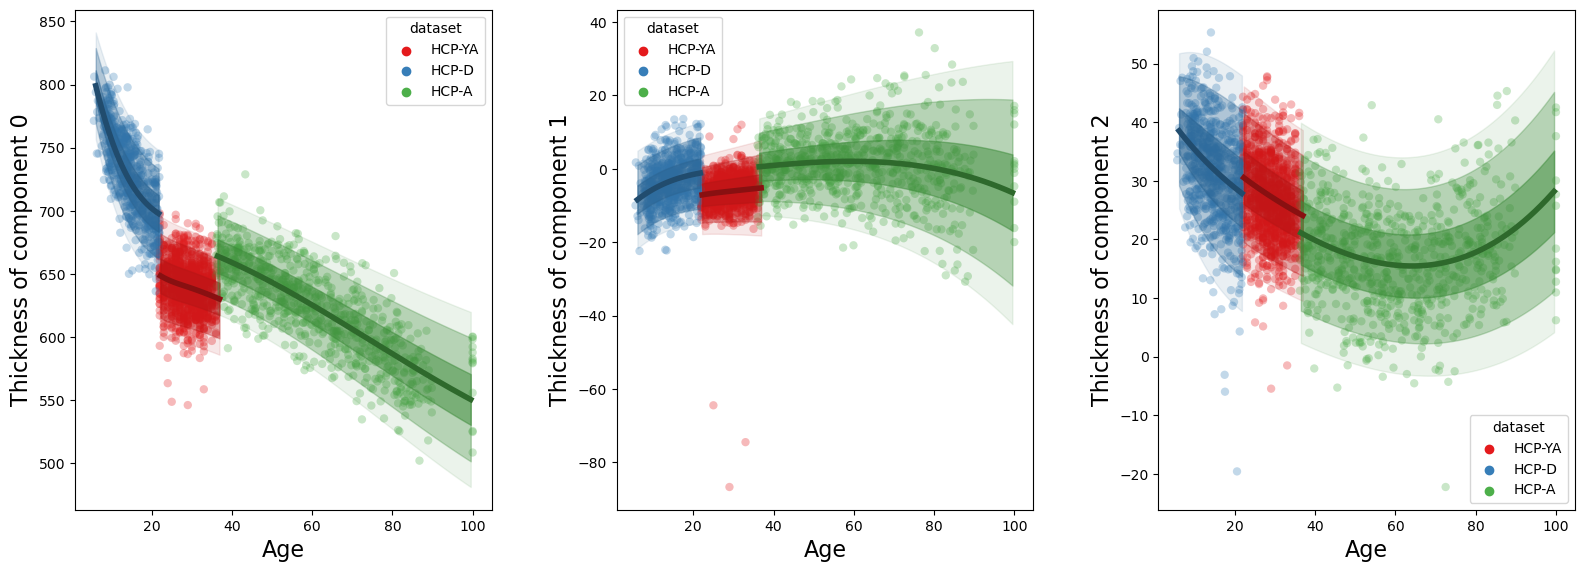

In [157]:
%%time

# sample from required columns
sample_df = train_df

# Data preperation
age = sample_df['age'].values
age_standardized = (age - age.mean()) / age.std()
site_idxs, sites = pd.factorize(sample_df['site'])
sex_idxs, sexes = pd.factorize(sample_df['sex'])


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for c in range(3):
    ax = axes[c]
    kernel_name = f'thickness_connectome_pc_{c}'
    thickness = sample_df[kernel_name].values
    thickness_mean = thickness.mean()
    thickness_std = thickness.std()
    thickness_standardized = (thickness - thickness_mean) / thickness_std
    
    sns.scatterplot(
        data=demography_extended_df,
        x='age',
        y=kernel_name,
        ax=ax,
        linewidth=0,
        hue='dataset',
        palette="Set1",
        alpha = 0.3,
    )

    ax.set_xlabel('Age', fontsize=16)
    ax.set_ylabel(f'Thickness of component {c}', fontsize=16)

    for idx in np.unique(site_idxs):
        xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
        selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
        # post = advi_model_idata.posterior
        advi_model_idata = az.from_netcdf(f'{main_dir}/data/models/pymc/connectome_rw_kernel/{kernel_name}_pymc_advi.nc')
        post = advi_model_idata.posterior

        prediction_B_spline_age = patsy.dmatrix(
            "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
            {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
        )

        y_ppc_mu = (
            post['intercept_sex'].stack(sample=("chain", "draw"))[0].data +
            post['intercept_site'].stack(sample=("chain", "draw"))[idx].data +
            np.dot(
                prediction_B_spline_age,
                post['w_age'].stack(sample=("chain", "draw"))
            )
        )
        y_ppc_mu_mean = y_ppc_mu.mean(1)

        y_ppc_sigma = (
            post['error_sex'].stack(sample=("chain", "draw"))[0].data +
            post['error_site'].stack(sample=("chain", "draw"))[idx].data +
            np.dot(
                prediction_B_spline_age,
                post['w_error_age'].stack(sample=("chain", "draw"))
            )
        )
        y_ppc_sigma_mean = y_ppc_sigma.mean(1)

        # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data

        # need to ensure the correctness
        quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]

        thickness_quantiles = {
            q: (
                (
                    y_ppc_mu_mean + stats.norm.ppf(q=q) * y_ppc_sigma_mean
                )  * thickness_std +
                thickness_mean
            ) for q in quantiles
        }

        # centile plot
        for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
            ax.fill_between(
                xi[selection],
                thickness_quantiles[q1][selection],
                thickness_quantiles[q2][selection],
                alpha=alpha,
                color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
            )

        ax.plot(
            xi[selection],
            thickness_quantiles[0.5][selection],
            c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
            lw=4,
        )

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.)


CPU times: user 9.34 s, sys: 16.9 s, total: 26.2 s
Wall time: 2.75 s


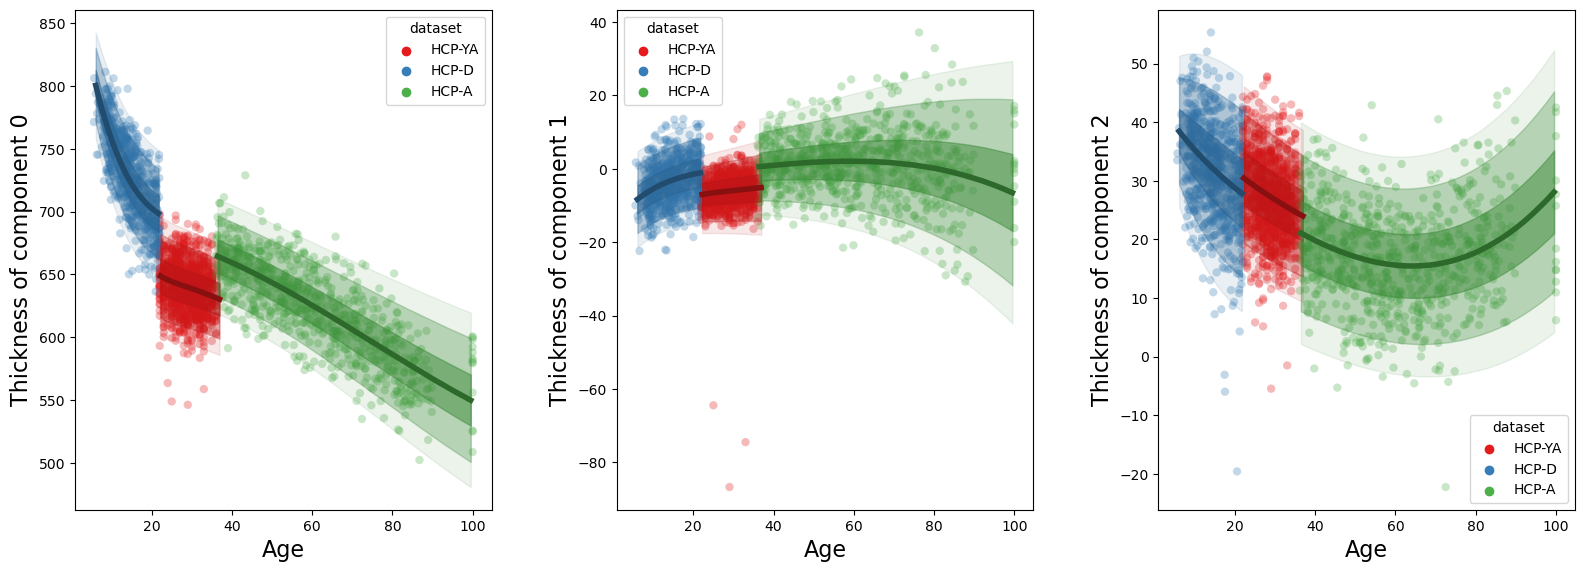

In [176]:
%%time

# sample from required columns
sample_df = demography_extended_df

# Data preperation
age = sample_df['age'].values
age_standardized = (age - age.mean()) / age.std()
site_idxs, sites = pd.factorize(sample_df['site'])
sex_idxs, sexes = pd.factorize(sample_df['sex'])


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for c in range(3):
    ax = axes[c]
    kernel_name = f'thickness_connectome_pc_{c}'
    thickness = sample_df[kernel_name].values
    thickness_mean = thickness.mean()
    thickness_std = thickness.std()
    thickness_standardized = (thickness - thickness_mean) / thickness_std
    
    sns.scatterplot(
        data=demography_extended_df,
        x='age',
        y=kernel_name,
        ax=ax,
        linewidth=0,
        hue='dataset',
        palette="Set1",
        alpha = 0.3,
    )

    ax.set_xlabel('Age', fontsize=16)
    ax.set_ylabel(f'Thickness of component {c}', fontsize=16)

    for idx in np.unique(site_idxs):
        xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
        selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
        # post = advi_model_idata.posterior
        advi_model_idata = az.from_netcdf(f'{main_dir}/data/models/pymc/connectome_rw_kernel/{kernel_name}_pymc_advi.nc')
        post = advi_model_idata.posterior

        prediction_B_spline_age = patsy.dmatrix(
            "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
            {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
        )

        y_ppc_mu = (
            post['intercept_sex'].stack(sample=("chain", "draw"))[0].data +
            post['intercept_site'].stack(sample=("chain", "draw"))[idx].data +
            np.dot(
                prediction_B_spline_age,
                post['w_age'].stack(sample=("chain", "draw"))
            )
        )
        y_ppc_mu_mean = y_ppc_mu.mean(1)

        y_ppc_sigma = (
            post['error_sex'].stack(sample=("chain", "draw"))[0].data +
            post['error_site'].stack(sample=("chain", "draw"))[idx].data +
            np.dot(
                prediction_B_spline_age,
                post['w_error_age'].stack(sample=("chain", "draw"))
            )
        )
        y_ppc_sigma_mean = y_ppc_sigma.mean(1)

        # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data

        # need to ensure the correctness
        quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]

        thickness_quantiles = {
            q: (
                (
                    np.quantile(((y_ppc_mu + stats.norm.ppf(q=q) * y_ppc_sigma)), 0.5, 1)
                    # np.quantile(((y_ppc_mu + stats.norm.ppf(q=q) * y_ppc_sigma)), q, 1)
                )  * thickness_std +
                thickness_mean
            ) for q in quantiles
        }

        # centile plot
        for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
            ax.fill_between(
                xi[selection],
                thickness_quantiles[q1][selection],
                thickness_quantiles[q2][selection],
                alpha=alpha,
                color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
            )

        ax.plot(
            xi[selection],
            thickness_quantiles[0.5][selection],
            c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
            lw=4,
        )

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.)


#### Load fitted kernel normative models

---


In [732]:
%%time
# Load all posterior distributions of kernels
kernel_idata = {}

N_kernels = 10000

# for i in tqdm(range(all_thickness_data_encoded.shape[1])):
for i in tqdm(range(N_kernels)):
    kernel_name = f'thickness_connectome_pc_{i}'
    kernel_idata[kernel_name] = az.from_netcdf(f'{main_dir}/data/models/pymc/connectome_rw_kernel/{kernel_name}_pymc_advi.nc')


  0%|          | 0/10000 [00:00<?, ?it/s]

/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/arviz/data/inference_data.py:146: UserWarning: training group is not defined in the InferenceData scheme
  warnings.warn(


CPU times: user 17min 8s, sys: 18.6 s, total: 17min 27s
Wall time: 17min 22s


In [733]:
%%time
# concatenate posteriors along a new dimension
# kernel_posteriors = xr.concat([kernel_idata[f'thickness_connectome_pc_{i}'].posterior for i in range(all_thickness_data_encoded.shape[1])], "kernel")
kernel_posteriors = xr.concat([kernel_idata[f'thickness_connectome_pc_{i}'].posterior for i in range(N_kernels)], "kernel")
kernel_posteriors


CPU times: user 41min 31s, sys: 57.6 s, total: 42min 28s
Wall time: 47min 47s


<xarray.Dataset>
Dimensions:                (chain: 1, draw: 2000, kernel: 10000, sex: 2,
                            site: 3, splines: 5)
Coordinates:
  * chain                  (chain) int64 0
  * draw                   (draw) int64 0 1 2 3 4 5 ... 1995 1996 1997 1998 1999
  * sex                    (sex) float64 1.0 0.0
  * site                   (site) object 'HCP-YA-site_0' ... 'HCP-A-site_0'
  * splines                (splines) int64 0 1 2 3 4
Dimensions without coordinates: kernel
Data variables:
    mu_intercept_site      (kernel, chain, draw) float64 0.008891 ... -0.006916
    intercept_sex          (kernel, chain, draw, sex) float64 0.01759 ... -0....
    intercept_site_offset  (kernel, chain, draw, site) float64 -0.5556 ... -0...
    w_age                  (kernel, chain, draw, splines) float64 2.305 ... -...
    sigma_intercept_site   (kernel, chain, draw) float64 0.6172 ... 0.05025
    sigma_error_site       (kernel, chain, draw) float64 0.02894 ... 0.01333
    w_error_age            (kernel, chain, draw, splines) float64 0.1369 ... ...
    error_sex              (kernel, chain, draw, sex) float64 0.1734 ... 0.4281
    error_site_offset      (kernel, chain, draw, site) float64 0.07595 ... 0....
    intercept_site         (kernel, chain, draw, site) float64 -0.334 ... -0....
    error_site             (kernel, chain, draw, site) float64 0.002198 ... 0...
Attributes:
    created_at:                 2023-12-29T07:54:18.553670
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  4.2.2

In [734]:
1

1

In [737]:
%%time
kernel_posteriors.to_netcdf(f'{main_dir}/data/models/pymc/combined_connectome_rw_kernel_posteriors_pymc_advi.nc')


CPU times: user 2min 3s, sys: 11.9 s, total: 2min 15s
Wall time: 2min 15s


In [738]:
%%time
kernel_posterior_means = kernel_posteriors.mean(dim=["chain", "draw"])
kernel_posterior_means


CPU times: user 8.21 s, sys: 3.98 s, total: 12.2 s
Wall time: 12.2 s


<xarray.Dataset>
Dimensions:                (kernel: 10000, sex: 2, site: 3, splines: 5)
Coordinates:
  * sex                    (sex) float64 1.0 0.0
  * site                   (site) object 'HCP-YA-site_0' ... 'HCP-A-site_0'
  * splines                (splines) int64 0 1 2 3 4
Dimensions without coordinates: kernel
Data variables:
    mu_intercept_site      (kernel) float64 -0.002209 -0.04212 ... -0.004221
    intercept_sex          (kernel, sex) float64 0.007511 -0.02902 ... -0.06486
    intercept_site_offset  (kernel, site) float64 -0.5207 0.6658 ... -0.2442
    w_age                  (kernel, splines) float64 2.28 -0.7554 ... -0.2568
    sigma_intercept_site   (kernel) float64 0.6414 0.6912 ... 0.02952 0.03268
    sigma_error_site       (kernel) float64 0.03551 0.3698 ... 0.06692 0.02371
    w_error_age            (kernel, splines) float64 0.1704 0.2597 ... 0.3107
    error_sex              (kernel, sex) float64 0.1536 0.1877 ... 0.4135 0.4377
    error_site_offset      (kernel, site) float64 0.2661 1.161 ... 1.345 1.141
    intercept_site         (kernel, site) float64 -0.3362 0.4249 ... -0.01154
    error_site             (kernel, site) float64 0.009425 0.04126 ... 0.02684

In [750]:
%%time
kernel_posterior_means.to_netcdf(f'{main_dir}/data/models/pymc/combined_connectome_rw_kernel_posterior_means_pymc_advi.nc')


CPU times: user 75.9 ms, sys: 7.92 ms, total: 83.9 ms
Wall time: 81.8 ms


In [749]:
kernel_posterior_means.info()

xarray.Dataset {
dimensions:
	kernel = 10000 ;
	sex = 2 ;
	site = 3 ;
	splines = 5 ;

variables:
	float64 mu_intercept_site(kernel) ;
	float64 sex(sex) ;
	float64 intercept_sex(kernel, sex) ;
	object site(site) ;
	float64 intercept_site_offset(kernel, site) ;
	int64 splines(splines) ;
	float64 w_age(kernel, splines) ;
	float64 sigma_intercept_site(kernel) ;
	float64 sigma_error_site(kernel) ;
	float64 w_error_age(kernel, splines) ;
	float64 error_sex(kernel, sex) ;
	float64 error_site_offset(kernel, site) ;
	float64 intercept_site(kernel, site) ;
	float64 error_site(kernel, site) ;

// global attributes:
}

In [204]:
%%time

rho_kernel_idata = {}

for i in tqdm(range(selected_pairs.shape[0])):
    kernel_name1, kernel_name2 = f'thickness_connectome_pc_{selected_pairs[i][0]}', f'thickness_connectome_pc_{selected_pairs[i][1]}'
    rho_kernel_idata[(kernel_name1, kernel_name2)] = az.from_netcdf(f'{main_dir}/data/models/pymc/connectome_rw_kernel_rho/{kernel_name1},{kernel_name2}_pymc_advi_rho.nc')


  0%|          | 0/4261 [00:00<?, ?it/s]

CPU times: user 6min 44s, sys: 11.1 s, total: 6min 55s
Wall time: 15min 36s


In [205]:
%%time
# concatenate posteriors along a new dimension
rho_kernel_posteriors = xr.concat([rho_kernel_idata[(f'thickness_connectome_pc_{selected_pairs[i][0]}', f'thickness_connectome_pc_{selected_pairs[i][1]}')].posterior for i in range(selected_pairs.shape[0])], "kernel_pair")
rho_kernel_posteriors


CPU times: user 8min 16s, sys: 16.4 s, total: 8min 33s
Wall time: 13min 14s


<xarray.Dataset>
Dimensions:                    (chain: 1, draw: 2000, kernel_pair: 4261,
                                sex: 2, site: 3, splines: 5)
Coordinates:
  * chain                      (chain) int64 0
  * draw                       (draw) int64 0 1 2 3 4 ... 1996 1997 1998 1999
  * sex                        (sex) float64 1.0 0.0
  * site                       (site) object 'HCP-YA-site_0' ... 'HCP-A-site_0'
  * splines                    (splines) int64 0 1 2 3 4
Dimensions without coordinates: kernel_pair
Data variables:
    mu_intercept_site_rho      (kernel_pair, chain, draw) float64 0.4861 ... ...
    intercept_sex_rho          (kernel_pair, chain, draw, sex) float64 -0.734...
    intercept_site_offset_rho  (kernel_pair, chain, draw, site) float64 0.148...
    w_age_rho                  (kernel_pair, chain, draw, splines) float64 0....
    sigma_intercept_site_rho   (kernel_pair, chain, draw) float64 0.3543 ... ...
    intercept_site_rho         (kernel_pair, chain, draw, site) float64 0.538...
Attributes:
    created_at:                 2023-11-25T06:27:36.091019
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  4.2.2

In [206]:
%%time
rho_kernel_posteriors.to_netcdf(f'{main_dir}/data/models/pymc/combined_connectome_rw_rho_kernel_posteriors_pymc_advi.nc')


CPU times: user 27.9 s, sys: 3.83 s, total: 31.7 s
Wall time: 31.7 s


In [207]:
%%time
rho_kernel_posterior_means = rho_kernel_posteriors.mean(dim=["chain", "draw"])
rho_kernel_posterior_means


CPU times: user 1.79 s, sys: 1.12 s, total: 2.91 s
Wall time: 2.91 s


<xarray.Dataset>
Dimensions:                    (kernel_pair: 4261, sex: 2, site: 3, splines: 5)
Coordinates:
  * sex                        (sex) float64 1.0 0.0
  * site                       (site) object 'HCP-YA-site_0' ... 'HCP-A-site_0'
  * splines                    (splines) int64 0 1 2 3 4
Dimensions without coordinates: kernel_pair
Data variables:
    mu_intercept_site_rho      (kernel_pair) float64 0.4604 0.1131 ... -0.1323
    intercept_sex_rho          (kernel_pair, sex) float64 -0.7334 ... -0.1828
    intercept_site_offset_rho  (kernel_pair, site) float64 0.1477 ... 0.08474
    w_age_rho                  (kernel_pair, splines) float64 0.1955 ... -0.4974
    sigma_intercept_site_rho   (kernel_pair) float64 0.301 0.2911 ... 0.5272
    intercept_site_rho         (kernel_pair, site) float64 0.5049 ... -0.08757

In [208]:
%%time
rho_kernel_posterior_means.to_netcdf(f'{main_dir}/data/models/pymc/combined_connectome_rw_rho_kernel_posterior_means_pymc_advi.nc')


CPU times: user 36.7 ms, sys: 0 ns, total: 36.7 ms
Wall time: 35.7 ms


#### Modelling mean thickness 🧠

---


In [283]:
# mean thickness vector representation
mean_thickness_vector = np.ones(connectome_kernel_eigenvectors.shape[0]) / connectome_kernel_eigenvectors.shape[0]
mean_thickness_vector_encoded = np.dot(mean_thickness_vector.reshape(1,-1), connectome_kernel_eigenvectors[:, :N_kernels])


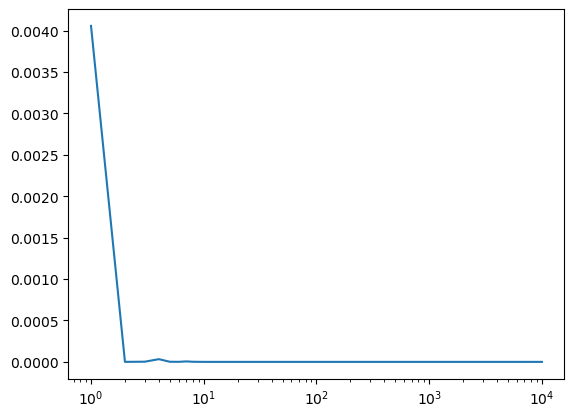

In [284]:
ax = sns.lineplot(y=(mean_thickness_vector_encoded.ravel()**2)/(np.linalg.norm(mean_thickness_vector_encoded)), x=1+np.arange(mean_thickness_vector_encoded.shape[1]))
ax.set_xscale('log')
# ax.set_yscale('log')


(0.8, 10000)

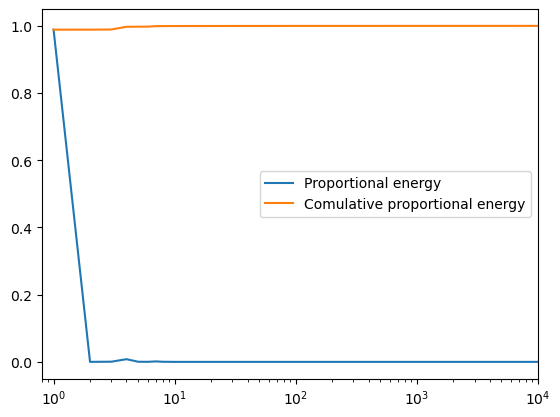

In [285]:
ax = sns.lineplot(
    y=(mean_thickness_vector_encoded.ravel()**2)/(np.linalg.norm(mean_thickness_vector)**2),
    x=1+np.arange(mean_thickness_vector_encoded.shape[1]), label='Proportional energy')
ax = sns.lineplot(
    y=np.cumsum(mean_thickness_vector_encoded.ravel()**2)/(np.linalg.norm(mean_thickness_vector)**2),
    x=1+np.arange(mean_thickness_vector_encoded.shape[1]), label='Comulative proportional energy')
ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim(0.1,1.1)
ax.set_xlim(0.8, N_kernels)

In [298]:
rho_ppc_mean.shape

(200, 4261)

/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


CPU times: user 1min 51s, sys: 821 ms, total: 1min 52s
Wall time: 1min 52s


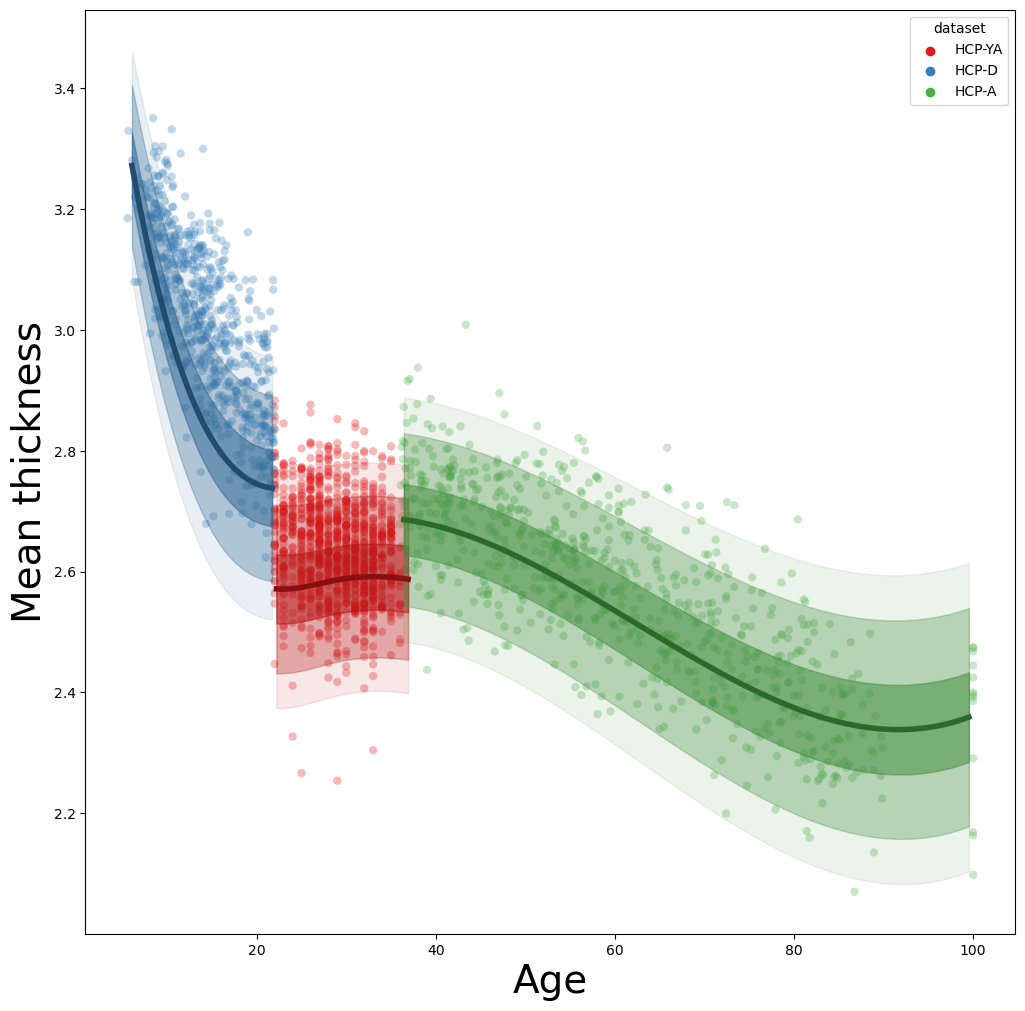

In [743]:
%%time

sigmoid = lambda x: 1/(1 + np.exp(-x))

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# thickness_mean = mean_thickness_vector_encoded.dot(all_thickness_data_encoded.mean(0))
# thickness_std = np.power(
#     np.multiply(
#         mean_thickness_vector_encoded.reshape(-1,),
#         all_thickness_data_encoded.std(0)
#     ).dot(
#         correlations
#     ).dot(
#         np.multiply(
#             mean_thickness_vector_encoded.reshape(-1,),
#             all_thickness_data_encoded.std(0)
#         ),
#     ),
#     0.5
# )

sns.scatterplot(
    data=demography_df,
    x='age',
    y='thickness',
    ax=ax,
    linewidth=0,
    hue='dataset',
    palette="Set1",
#     palette=mpl.cm.Set1,
    alpha = 0.3,
#     color=[0.3,0.6,0.9,0.5],
)

# ax.set_xlim(20,40)
# ax.set_ylim(2.2,3)

ax.set_xlabel('Age', fontsize=28)
ax.set_ylabel('Mean thickness', fontsize=28)

xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
    
prediction_B_spline_age = patsy.dmatrix(
    "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
    {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
)

sparse_filler = sparse.coo_matrix(
    (np.ones(selected_pairs.shape[0]), (selected_pairs[:, 0], selected_pairs[:, 1])),
    shape=(selected_pairs.max() + 1, selected_pairs.max() + 1)
    # shape=(kernel_posterior_means.dims['kernel'], kernel_posterior_means.dims['kernel'])
)
# sparse_filler = sparse_filler.tocsr()[:N_kernels, :N_kernels].tocoo()

for idx in np.unique(site_idxs):
    selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
    # post = advi_model_idata.posterior
    
    kernels_y_ppc_mu_mean = (
        kernel_posterior_means['intercept_sex'].isel(sex=0) +
        kernel_posterior_means['intercept_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            kernel_posterior_means['w_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded[:, :N_kernels].std(0), dims=["kernel"]) + xr.DataArray(all_thickness_data_encoded[:, :N_kernels].mean(0), dims=["kernel"])
    y_ppc_mu_mean = np.array(xr.dot(
        xr.DataArray(mean_thickness_vector_encoded.reshape(-1), dims=["kernel"]),
        kernels_y_ppc_mu_mean
    ))
    
    rho_ppc_mean = 2 * sigmoid(
        rho_kernel_posterior_means['intercept_sex_rho'].isel(sex=0).data +
        rho_kernel_posterior_means['intercept_site_rho'].isel(site=idx).data +
        xr.DataArray(prediction_B_spline_age, dims=["obs_id", "splines"]).dot(
            rho_kernel_posterior_means['w_age_rho']
        )
    ) - 1

    kernels_y_ppc_sigma_mean = (
        kernel_posterior_means['error_sex'].isel(sex=0) +
        kernel_posterior_means['error_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            kernel_posterior_means['w_error_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded[:, :N_kernels].std(0), dims=["kernel"])
    y_ppc_sigma_mean = np.zeros(200)
    for i in range(200):
        sparse_correlations = sparse_filler.copy()
        sparse_correlations.data = rho_ppc_mean[i]
        sparse_correlations = (sparse_correlations + sparse_correlations.T)
        sparse_correlations.setdiag(1)
        # sparse_correlations = sparse_correlations.tocsr()
        sparse_correlations = sparse_correlations.tocsr()[:N_kernels, :N_kernels]
        y_ppc_sigma_mean[i] = np.power(
            sparse_correlations.dot(
                np.multiply(
                    mean_thickness_vector_encoded.reshape(-1,),
                    np.array(kernels_y_ppc_sigma_mean).T[i]
                )
            ).dot(
                np.multiply(
                    mean_thickness_vector_encoded.reshape(-1,),
                    np.array(kernels_y_ppc_sigma_mean).T[i]
                ),
            ),
            0.5
        )

    # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data
    
    # need to ensure the correctness
    quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]
    
    thickness_quantiles = {
        q: (
            (
                y_ppc_mu_mean + stats.norm.ppf(q=q) * y_ppc_sigma_mean
            )
            # * thickness_std +
            # thickness_mean
        ) for q in quantiles
    }

    # centile plot
    for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
        ax.fill_between(
            xi[selection],
            thickness_quantiles[q1][selection],
            thickness_quantiles[q2][selection],
            alpha=alpha,
            color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
        )
    
    ax.plot(
        xi[selection],
        thickness_quantiles[0.5][selection],
        c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
        lw=4,
    )


/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


CPU times: user 1min 29s, sys: 1.39 s, total: 1min 31s
Wall time: 1min 30s


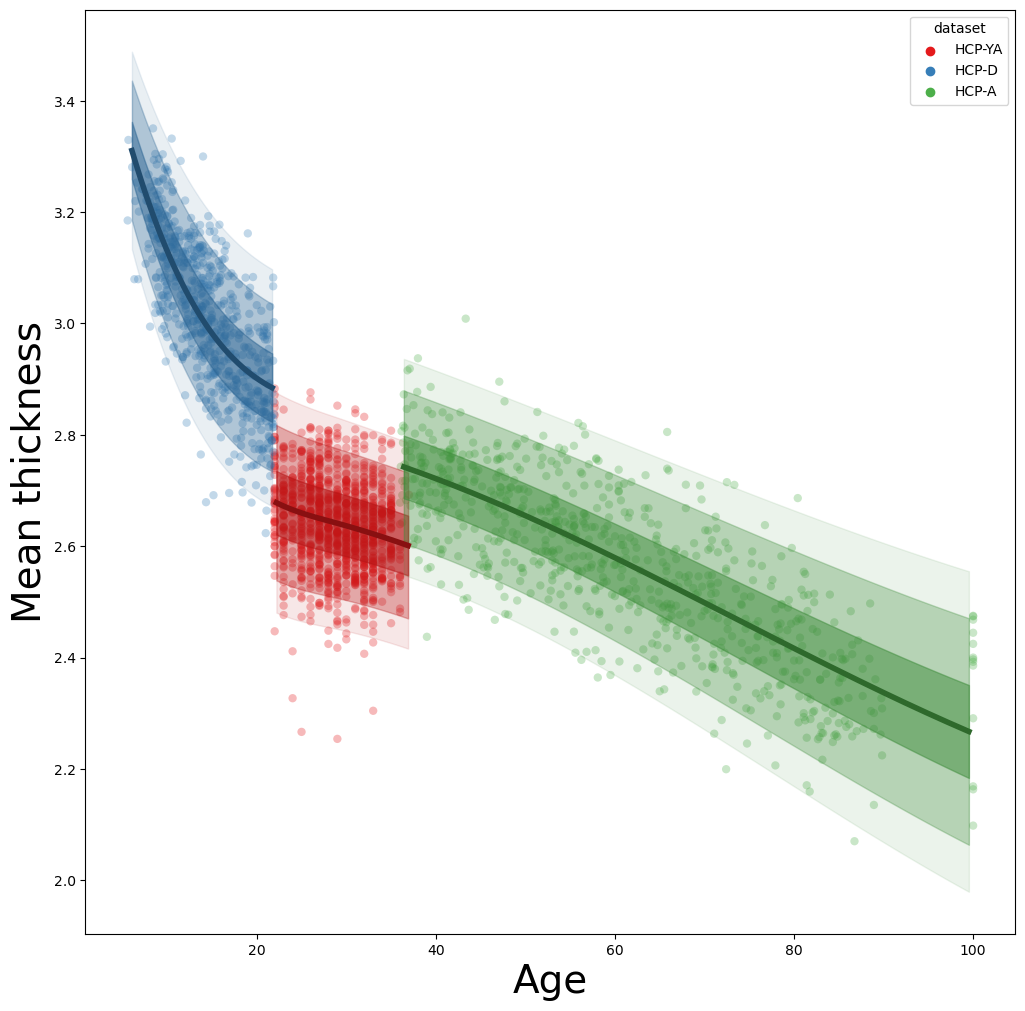

In [300]:
%%time

sigmoid = lambda x: 1/(1 + np.exp(-x))

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# thickness_mean = mean_thickness_vector_encoded.dot(all_thickness_data_encoded.mean(0))
# thickness_std = np.power(
#     np.multiply(
#         mean_thickness_vector_encoded.reshape(-1,),
#         all_thickness_data_encoded.std(0)
#     ).dot(
#         correlations
#     ).dot(
#         np.multiply(
#             mean_thickness_vector_encoded.reshape(-1,),
#             all_thickness_data_encoded.std(0)
#         ),
#     ),
#     0.5
# )

sns.scatterplot(
    data=demography_df,
    x='age',
    y='thickness',
    ax=ax,
    linewidth=0,
    hue='dataset',
    palette="Set1",
#     palette=mpl.cm.Set1,
    alpha = 0.3,
#     color=[0.3,0.6,0.9,0.5],
)

# ax.set_xlim(20,40)
# ax.set_ylim(2.2,3)

ax.set_xlabel('Age', fontsize=28)
ax.set_ylabel('Mean thickness', fontsize=28)

xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
    
prediction_B_spline_age = patsy.dmatrix(
    "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
    {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
)

sparse_filler = sparse.coo_matrix(
    (np.ones(selected_pairs.shape[0]), (selected_pairs[:, 0], selected_pairs[:, 1])),
    shape=(selected_pairs.max() + 1, selected_pairs.max() + 1)
    # shape=(kernel_posterior_means.dims['kernel'], kernel_posterior_means.dims['kernel'])
)
# sparse_filler = sparse_filler.tocsr()[:N_kernels, :N_kernels].tocoo()

for idx in np.unique(site_idxs):
    selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
    # post = advi_model_idata.posterior
    
    kernels_y_ppc_mu_mean = (
        kernel_posterior_means['intercept_sex'].isel(sex=0) +
        kernel_posterior_means['intercept_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            kernel_posterior_means['w_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded[:, :N_kernels].std(0), dims=["kernel"]) + xr.DataArray(all_thickness_data_encoded[:, :N_kernels].mean(0), dims=["kernel"])
    y_ppc_mu_mean = np.array(xr.dot(
        xr.DataArray(mean_thickness_vector_encoded.reshape(-1), dims=["kernel"]),
        kernels_y_ppc_mu_mean
    ))
    
    rho_ppc_mean = 2 * sigmoid(
        rho_kernel_posterior_means['intercept_sex_rho'].isel(sex=0).data +
        rho_kernel_posterior_means['intercept_site_rho'].isel(site=idx).data +
        xr.DataArray(prediction_B_spline_age, dims=["obs_id", "splines"]).dot(
            rho_kernel_posterior_means['w_age_rho']
        )
    ) - 1

    kernels_y_ppc_sigma_mean = (
        kernel_posterior_means['error_sex'].isel(sex=0) +
        kernel_posterior_means['error_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            kernel_posterior_means['w_error_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded[:, :N_kernels].std(0), dims=["kernel"])
    y_ppc_sigma_mean = np.zeros(200)
    for i in range(200):
        sparse_correlations = sparse_filler.copy()
        sparse_correlations.data = rho_ppc_mean[i]
        sparse_correlations = (sparse_correlations + sparse_correlations.T)
        sparse_correlations.setdiag(1)
        # sparse_correlations = sparse_correlations.tocsr()
        sparse_correlations = sparse_correlations.tocsr()[:N_kernels, :N_kernels]
        y_ppc_sigma_mean[i] = np.power(
            sparse_correlations.dot(
                np.multiply(
                    mean_thickness_vector_encoded.reshape(-1,),
                    np.array(kernels_y_ppc_sigma_mean).T[i]
                )
            ).dot(
                np.multiply(
                    mean_thickness_vector_encoded.reshape(-1,),
                    np.array(kernels_y_ppc_sigma_mean).T[i]
                ),
            ),
            0.5
        )

    # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data
    
    # need to ensure the correctness
    quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]
    
    thickness_quantiles = {
        q: (
            (
                y_ppc_mu_mean + stats.norm.ppf(q=q) * y_ppc_sigma_mean
            )
            # * thickness_std +
            # thickness_mean
        ) for q in quantiles
    }

    # centile plot
    for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
        ax.fill_between(
            xi[selection],
            thickness_quantiles[q1][selection],
            thickness_quantiles[q2][selection],
            alpha=alpha,
            color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
        )
    
    ax.plot(
        xi[selection],
        thickness_quantiles[0.5][selection],
        c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
        lw=4,
    )


#### A short note on fixing the spline function and its potential benefits

---


In [473]:
xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
    
prediction_B_spline_age = patsy.dmatrix(
    "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
    {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
)

plt.plot(xi, prediction_B_spline_age)

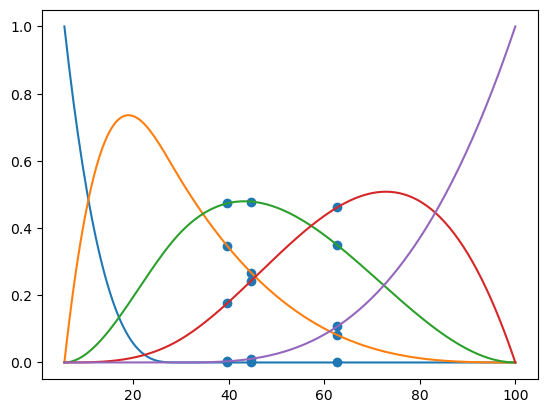

In [641]:
myxi = xr.DataArray(np.random.rand(3)*(np.max(age) - np.min(age))+np.min(age), dims=["obs_id"])
myxi = xr.DataArray(np.random.rand(3)*(np.max(age) - np.min(age))+np.min(age), dims=["obs_id"])

my_B_spline_age = patsy.build_design_matrices([prediction_B_spline_age.design_info], {"xi": ((myxi - age.mean()) / age.std()), "knots": knot_list[1:-1]})

plt.plot(xi, prediction_B_spline_age)
plt.scatter(np.repeat(myxi,5), my_B_spline_age)


In [646]:
# myxi = xr.DataArray(np.random.rand(3)*(np.max(age) - np.min(age))+np.min(age), dims=["obs_id"])
myxi = xr.DataArray(age, dims=["obs_id"])

my_B_spline_age = patsy.build_design_matrices([prediction_B_spline_age.design_info], {"xi": ((myxi - age.mean()) / age.std()), "knots": knot_list[1:-1]})

plt.plot(xi, prediction_B_spline_age)
plt.scatter(np.repeat(myxi,5), my_B_spline_age)


In [423]:
np.min(age), np.max(age)

(5.583333333333332, 100.0)

In [426]:
age.mean(), age.std()

(34.25977220649683, 19.981991656096923)

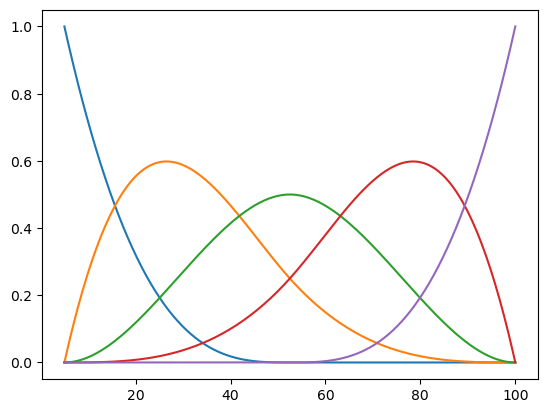

In [475]:
# fixed B-spline   
fixed_B_spline_age = patsy.dmatrix(
    "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
    {"xi": (np.linspace(0, 110, 200)), "knots": np.linspace(0, 110, 3)[1:-1]},
)
plt.plot(np.linspace(5, 100, 200), fixed_B_spline_age)


#### Computing mean absolute error for the direct and indirect models

---


In [477]:
%%time

subj = demography_df.loc[0]
print(subj[['age','sex','siteCode']])

single_B_spline_age = patsy.build_design_matrices(
    [prediction_B_spline_age.design_info],
    {"xi": [((subj['age'] - age.mean()) / age.std())], "knots": knot_list[1:-1]}
)

kernels_y_ppc_mu_mean = (
    kernel_posterior_means['intercept_sex'].isel(sex=int(subj['sex'])) +
    kernel_posterior_means['intercept_site'].isel(site=subj['siteCode']) +
    xr.dot(
        xr.DataArray(np.asarray(single_B_spline_age)[0], dims=["obs_id", "splines"]),
        kernel_posterior_means['w_age']
    )
) * xr.DataArray(all_thickness_data_encoded[:, :N_kernels].std(0), dims=["kernel"]) + xr.DataArray(all_thickness_data_encoded[:, :N_kernels].mean(0), dims=["kernel"])
y_ppc_mu_mean = np.array(xr.dot(
    xr.DataArray(mean_thickness_vector_encoded.reshape(-1), dims=["kernel"]),
    kernels_y_ppc_mu_mean
))
print(y_ppc_mu_mean, mean_thickness_vector_encoded.dot(all_thickness_data_encoded[0, :N_kernels]))


age         32.0
sex          1.0
siteCode       0
Name: 0, dtype: object
[2.6197902] [2.63638711]
CPU times: user 125 ms, sys: 55.9 ms, total: 181 ms
Wall time: 179 ms


In [ ]:
[train_df.loc[x] for x in train_df.index]

In [511]:
predictions = []

for i in tqdm(train_df.index):
    subj = train_df.loc[i]

    single_B_spline_age = patsy.build_design_matrices(
        [prediction_B_spline_age.design_info],
        {"xi": [((subj['age'] - age.mean()) / age.std())], "knots": knot_list[1:-1]}
    )

    kernels_y_ppc_mu_mean = (
        kernel_posterior_means['intercept_sex'].isel(sex=int(subj['sex'])) +
        kernel_posterior_means['intercept_site'].isel(site=subj['siteCode']) +
        xr.dot(
            xr.DataArray(np.asarray(single_B_spline_age)[0], dims=["obs_id", "splines"]),
            kernel_posterior_means['w_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded[:, :N_kernels].std(0), dims=["kernel"]) + xr.DataArray(all_thickness_data_encoded[:, :N_kernels].mean(0), dims=["kernel"])
    y_ppc_mu_mean = np.array(xr.dot(
        xr.DataArray(mean_thickness_vector_encoded.reshape(-1), dims=["kernel"]),
        kernels_y_ppc_mu_mean
    ))
    predictions.append(y_ppc_mu_mean)


  0%|          | 0/1978 [00:00<?, ?it/s]

In [499]:
sns.scatterplot(x=train_df['thickness'], y=np.array(predictions).ravel(), hue=train_df['site'], alpha=0.5)

<AxesSubplot: xlabel='thickness'>

In [500]:
np.corrcoef(x=train_df['thickness'], y=np.array(predictions).ravel())

array([[1.        , 0.91207031],
       [0.91207031, 1.        ]])

In [502]:
from sklearn import metrics
metrics.mean_absolute_error(train_df['thickness'], np.array(predictions).ravel())

0.07038067414973036

In [507]:
# naive mean estimator
metrics.mean_absolute_error(train_df['thickness'], np.repeat(train_df['thickness'].mean(), train_df['thickness'].shape[0]))


0.1688876150173087

In [512]:
test_predictions = []

for i in tqdm(test_df.index):
    subj = test_df.loc[i]

    single_B_spline_age = patsy.build_design_matrices(
        [prediction_B_spline_age.design_info],
        {"xi": [((subj['age'] - age.mean()) / age.std())], "knots": knot_list[1:-1]}
    )

    kernels_y_ppc_mu_mean = (
        kernel_posterior_means['intercept_sex'].isel(sex=int(subj['sex'])) +
        kernel_posterior_means['intercept_site'].isel(site=subj['siteCode']) +
        xr.dot(
            xr.DataArray(np.asarray(single_B_spline_age)[0], dims=["obs_id", "splines"]),
            kernel_posterior_means['w_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded[:, :N_kernels].std(0), dims=["kernel"]) + xr.DataArray(all_thickness_data_encoded[:, :N_kernels].mean(0), dims=["kernel"])
    y_ppc_mu_mean = np.array(xr.dot(
        xr.DataArray(mean_thickness_vector_encoded.reshape(-1), dims=["kernel"]),
        kernels_y_ppc_mu_mean
    ))
    test_predictions.append(y_ppc_mu_mean)


  0%|          | 0/495 [00:00<?, ?it/s]

<AxesSubplot: xlabel='thickness'>

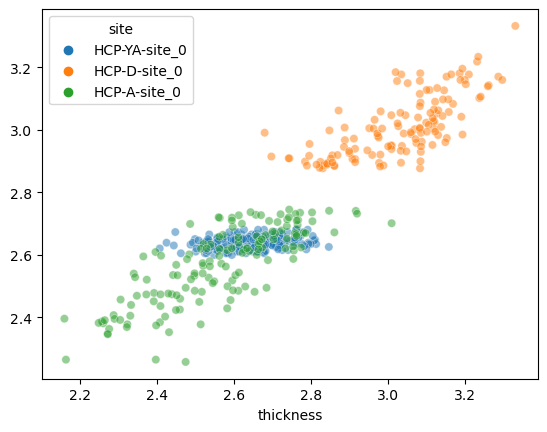

In [518]:
sns.scatterplot(x=test_df['thickness'], y=np.array(test_predictions).ravel(), hue=test_df['site'], alpha=0.5)

In [519]:
np.corrcoef(x=test_df['thickness'], y=np.array(test_predictions).ravel())

array([[1.        , 0.91702597],
       [0.91702597, 1.        ]])

In [520]:
from sklearn import metrics
metrics.mean_absolute_error(test_df['thickness'], np.array(test_predictions).ravel())

0.07308924774889788

In [522]:
# naive mean estimator
metrics.mean_absolute_error(test_df['thickness'], np.repeat(train_df['thickness'].mean(), test_df['thickness'].shape[0]))


0.17511215255765927

In [524]:
(feature_name, feature_advi_model, feature_advi_model_idata) = run_pymc_advi_for_feature(train_df, 'thickness')

Finished [100%]: Average Loss = 294.95
Sampling: [error_sex, error_site_offset, intercept_sex, intercept_site_offset, mu_intercept_site, sigma_error_site, sigma_intercept_site, thickness_like, w_age, w_error_age]
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation thickness_like
  warnings.warn(f"Could not extract data from symbolic observation {obs}")
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation thickness_like
  warnings.warn(f"Could not extract data from symbolic observation {obs}")
Sampling: [thickness_like]


/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation thickness_like
  warnings.warn(f"Could not extract data from symbolic observation {obs}")


In [527]:
feature_posterior_mean['intercept_sex'].isel(sex=int(subj['sex']))

<xarray.DataArray 'intercept_sex' ()>
array(-0.02470608)
Coordinates:
    sex      float64 0.0

In [531]:
train_df['thickness'].mean()

2.716510169275346

In [532]:
feature_posterior_mean = feature_advi_model_idata.posterior.mean(dim=["chain", "draw"])

direct_predictions = []

for i in tqdm(train_df.index):
    subj = train_df.loc[i]

    single_B_spline_age = patsy.build_design_matrices(
        [prediction_B_spline_age.design_info],
        {"xi": [((subj['age'] - age.mean()) / age.std())], "knots": knot_list[1:-1]}
    )

    y_ppc_mu_mean = (
        feature_posterior_mean['intercept_sex'].isel(sex=int(subj['sex'])) +
        feature_posterior_mean['intercept_site'].isel(site=subj['siteCode']) +
        xr.dot(
            xr.DataArray(np.asarray(single_B_spline_age)[0], dims=["obs_id", "splines"]),
            feature_posterior_mean['w_age']
        )
    ) * train_df['thickness'].std() + train_df['thickness'].mean()
    direct_predictions.append(y_ppc_mu_mean)


  0%|          | 0/1978 [00:00<?, ?it/s]

<AxesSubplot: xlabel='thickness'>

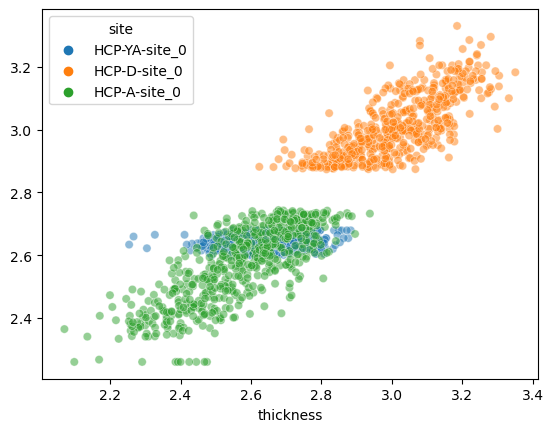

In [533]:
sns.scatterplot(x=train_df['thickness'], y=np.array(direct_predictions).ravel(), hue=train_df['site'], alpha=0.5)

In [534]:
np.corrcoef(x=train_df['thickness'], y=np.array(direct_predictions).ravel())

array([[1.        , 0.91207081],
       [0.91207081, 1.        ]])

In [535]:
from sklearn import metrics
metrics.mean_absolute_error(train_df['thickness'], np.array(direct_predictions).ravel())

0.07039102794234765

In [507]:
# naive mean estimator
metrics.mean_absolute_error(train_df['thickness'], np.repeat(train_df['thickness'].mean(), train_df['thickness'].shape[0]))


0.1688876150173087

In [536]:
feature_posterior_mean = feature_advi_model_idata.posterior.mean(dim=["chain", "draw"])

direct_test_predictions = []

for i in tqdm(test_df.index):
    subj = test_df.loc[i]

    single_B_spline_age = patsy.build_design_matrices(
        [prediction_B_spline_age.design_info],
        {"xi": [((subj['age'] - age.mean()) / age.std())], "knots": knot_list[1:-1]}
    )

    y_ppc_mu_mean = (
        feature_posterior_mean['intercept_sex'].isel(sex=int(subj['sex'])) +
        feature_posterior_mean['intercept_site'].isel(site=subj['siteCode']) +
        xr.dot(
            xr.DataArray(np.asarray(single_B_spline_age)[0], dims=["obs_id", "splines"]),
            feature_posterior_mean['w_age']
        )
    ) * train_df['thickness'].std() + train_df['thickness'].mean()
    direct_test_predictions.append(y_ppc_mu_mean)


  0%|          | 0/495 [00:00<?, ?it/s]

<AxesSubplot: xlabel='thickness'>

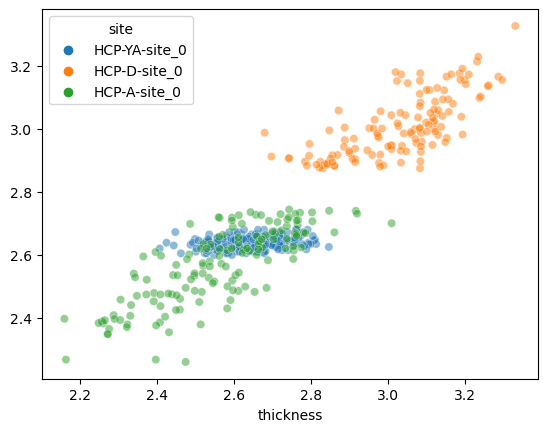

In [537]:
sns.scatterplot(x=test_df['thickness'], y=np.array(direct_test_predictions).ravel(), hue=test_df['site'], alpha=0.5)

In [538]:
np.corrcoef(x=test_df['thickness'], y=np.array(direct_test_predictions).ravel())

array([[1.       , 0.9170346],
       [0.9170346, 1.       ]])

In [539]:
from sklearn import metrics
metrics.mean_absolute_error(test_df['thickness'], np.array(direct_test_predictions).ravel())

0.07333678524326659

In [522]:
# naive mean estimator
metrics.mean_absolute_error(test_df['thickness'], np.repeat(train_df['thickness'].mean(), test_df['thickness'].shape[0]))


0.17511215255765927

In [523]:
def run_pymc_advi_for_feature(input_df, feature_name):
    # sample from required columns
    sample_df = input_df[['age', 'site', 'sex', feature_name]].copy()

    # Data preperation
    age = sample_df['age'].values
    age_standardized = (age - age.mean()) / age.std()
    thickness = sample_df[feature_name].values
    thickness_standardized = (thickness - thickness.mean()) / thickness.std()
    site_idxs, sites = pd.factorize(sample_df['site'])
    sex_idxs, sexes = pd.factorize(sample_df['sex'])
   
    # Splines to model nonlinear age effects on thickness
    # number of spline nuts (could be tuned)
    num_knots = 3
    knot_list = np.quantile(age_standardized, np.linspace(0, 1, num_knots))
    # create b spline basis for regression using patsy
    B_spline_age = patsy.dmatrix(
        "bs(age_standardized, knots=knots, degree=3, include_intercept=True) - 1",
        {"age_standardized": age_standardized, "knots": knot_list[1:-1]},
    )

    coords = {
        "site": sites,
        "sex": sexes,
        "splines": np.arange(B_spline_age.shape[1]),
        "obs_id": np.arange(len(site_idxs)),
    }

    feature_advi_model = pm.Model(coords=coords, aesara_config={'compute_test_value': 'off'})
    # models_dict[kernel_name] = advi_model

    # a nonlinear spline model (see https://www.pymc.io/projects/examples/en/latest/case_studies/spline.html)
    with feature_advi_model:
        # minibatch variables
        age_standardized_t = pm.Minibatch(age_standardized, 512,)
        sex_idx_t = pm.Minibatch(sex_idxs, 512)
        site_idx_t = pm.Minibatch(site_idxs, 512)
        B_spline_age_t = pm.Minibatch(B_spline_age, 512)
        thickness_standardized_t = pm.Minibatch(thickness_standardized, 512)

        # Hyperpriors for site groups (as if we have random group effects)
        mu_intercept_site = pm.Normal('mu_intercept_site', mu=0, sigma=10)
        sigma_intercept_site = pm.HalfNormal("sigma_intercept_site", sigma=10)
        sigma_error_site = pm.HalfNormal("sigma_error_site", sigma=10)

        # Priors    
        # sex effects (similar to fixed sex effects (intercept only))
        intercept_sex = pm.Normal("intercept_sex", mu=0, sigma=10, dims="sex")

        # site effects (similar to random site effects (intercept only))
        #a_site = pm.Normal("a_site", mu=mu_a_site, sigma=sigma_a_site, dims="site")
        intercept_site_offset = pm.Normal("intercept_site_offset", mu=0, sigma=1, dims="site")
        intercept_site = pm.Deterministic("intercept_site", mu_intercept_site + intercept_site_offset * sigma_intercept_site, dims="site")

        # age splines
        w_age = pm.Normal("w_age", mu=0, sigma=10, size=B_spline_age.shape[1], dims="splines")

        # Estimated thickness
        # thickness_est = pm.Deterministic("thickness_est", intercept_sex[sex_idx_t] + intercept_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_age.T))
        thickness_est = intercept_sex[sex_idx_t] + intercept_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_age.T)

        # Model error
        # nonlinear age error
        w_error_age = pm.HalfCauchy("w_error_age", beta=5, size=B_spline_age.shape[1], dims="splines")

        # constant sex error
        error_sex = pm.HalfCauchy("error_sex", beta=5, dims="sex")

        # random site error
        error_site_offset = pm.HalfCauchy("error_site_offset", beta=5, dims="site")
        error_site = pm.Deterministic("error_site", error_site_offset * sigma_error_site, dims="site")

        # Error estimate
        # thickness_error = pm.Deterministic("thickness_error", error_sex[sex_idx_t] + error_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age.T))
        thickness_error = error_sex[sex_idx_t] + error_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age.T)

        # Skewness estimate
        # thickness_skewness = pm.Normal("thickness_skewness", mu=0, sigma=10, total_size=len(sample_df))
        # for sake of simplicity let's not model skewness

        # Likelihood (sampling distribution) of observations
        # need to figure out how to bound the distribution
        # pm.Bound("thickness_like", pm.Normal, lower=(-thickness.mean() / thickness.std()))(
        # thickness_like = pm.SkewNormal(
        thickness_like = pm.Normal(
            "thickness_like",
            mu=thickness_est,
            sigma=thickness_error,
            observed=thickness_standardized_t,
            total_size=len(sample_df),
        )
            # alpha=thickness_skewness,
    
        # run ADVI with minibatch
        feature_approx = pm.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])

        # sample from trace
        feature_advi_model_idata = pm.sample_prior_predictive()
        feature_advi_model_idata.extend(feature_approx.sample(2000))
        pm.sample_posterior_predictive(feature_advi_model_idata, extend_inferencedata=True)
        # idata_dict[kernel_name] = advi_model_idata
    
    # stored_model_file = f'{main_dir}/data/models/pymc/css_kernel/{kernel_name}_pymc_advi.nc'
    # kernel_advi_model_idata.to_netcdf(ensure_dir(stored_model_file))
    # return (kernel_name, stored_model_file)
    return (feature_name, feature_advi_model, feature_advi_model_idata)
    

#### Computing mean standardized log loss for the direct and indirect models

---

In addition to estimates of mean, we need estimates of deviation:


In [567]:
predictions = []

for i in tqdm(train_df.index):
    subj = train_df.loc[i]

    single_B_spline_age = patsy.build_design_matrices(
        [prediction_B_spline_age.design_info],
        {"xi": [((subj['age'] - age.mean()) / age.std())], "knots": knot_list[1:-1]}
    )

    kernels_y_ppc_mu_mean = (
        kernel_posterior_means['intercept_sex'].isel(sex=int(subj['sex'])) +
        kernel_posterior_means['intercept_site'].isel(site=subj['siteCode']) +
        xr.dot(
            xr.DataArray(np.asarray(single_B_spline_age)[0], dims=["obs_id", "splines"]),
            kernel_posterior_means['w_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded[:, :N_kernels].std(0), dims=["kernel"]) + xr.DataArray(all_thickness_data_encoded[:, :N_kernels].mean(0), dims=["kernel"])
    y_ppc_mu_mean = np.array(xr.dot(
        xr.DataArray(mean_thickness_vector_encoded.reshape(-1), dims=["kernel"]),
        kernels_y_ppc_mu_mean
    ))
    predictions.append(y_ppc_mu_mean)


  0%|          | 0/1978 [00:00<?, ?it/s]

In [550]:
sigmoid = lambda x: 1/(1 + np.exp(-x))

predictions_sigma = []

for i in tqdm(train_df.index):
    subj = train_df.loc[i]

    single_B_spline_age = patsy.build_design_matrices(
        [prediction_B_spline_age.design_info],
        {"xi": [((subj['age'] - age.mean()) / age.std())], "knots": knot_list[1:-1]}
    )
    
    rho_ppc_mean = 2 * sigmoid(
        rho_kernel_posterior_means['intercept_sex_rho'].isel(sex=int(subj['sex'])).data +
        rho_kernel_posterior_means['intercept_site_rho'].isel(site=subj['siteCode']).data +
        xr.DataArray(np.asarray(single_B_spline_age)[0], dims=["obs_id", "splines"]).dot(
            rho_kernel_posterior_means['w_age_rho']
        )
    ) - 1

    kernels_y_ppc_sigma_mean = (
        kernel_posterior_means['error_sex'].isel(sex=int(subj['sex'])) +
        kernel_posterior_means['error_site'].isel(site=subj['siteCode']) +
        xr.dot(
            xr.DataArray(np.asarray(single_B_spline_age)[0], dims=["obs_id", "splines"]),
            kernel_posterior_means['w_error_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded[:, :N_kernels].std(0), dims=["kernel"])

    sparse_correlations = sparse_filler.copy()
    sparse_correlations.data = rho_ppc_mean[0]
    sparse_correlations = (sparse_correlations + sparse_correlations.T)
    sparse_correlations.setdiag(1)
    # sparse_correlations = sparse_correlations.tocsr()
    sparse_correlations = sparse_correlations.tocsr()[:N_kernels, :N_kernels]
    y_ppc_sigma_mean = np.power(
        sparse_correlations.dot(
            np.multiply(
                mean_thickness_vector_encoded.reshape(-1,),
                np.array(kernels_y_ppc_sigma_mean).T[0]
            )
        ).dot(
            np.multiply(
                mean_thickness_vector_encoded.reshape(-1,),
                np.array(kernels_y_ppc_sigma_mean).T[0]
            ),
        ),
        0.5
    )

    predictions_sigma.append(y_ppc_sigma_mean)


  0%|          | 0/1978 [00:00<?, ?it/s]

/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/mountpoint/code

In [568]:
# reference/trivial model
ref_mean = train_df['thickness'].mean()
ref_sigma = train_df['thickness'].std()

trivial_log_loss = stats.norm.logpdf(train_df['thickness'], loc=ref_mean, scale=ref_sigma)


In [594]:
# kernel model
kernel_log_loss = np.array(
    [
        stats.norm.logpdf(train_df.iloc[i]['thickness'], loc=predictions[i], scale=predictions_sigma[i])
        for i in tqdm(range(train_df.shape[0]))
    ]
).T[0]


  0%|          | 0/1978 [00:00<?, ?it/s]

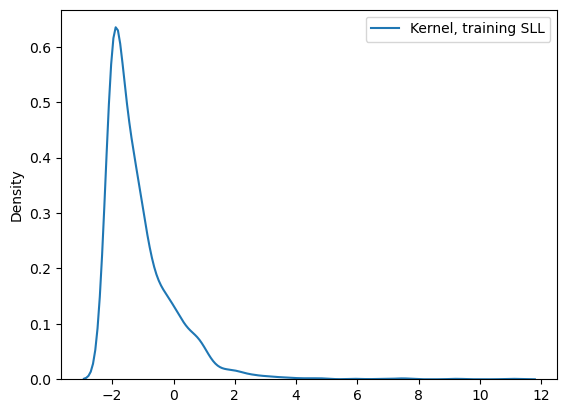

In [598]:
ax = sns.kdeplot(- kernel_log_loss - trivial_log_loss, label="Kernel, training SLL")
ax.legend()

In [512]:
test_predictions = []

for i in tqdm(test_df.index):
    subj = test_df.loc[i]

    single_B_spline_age = patsy.build_design_matrices(
        [prediction_B_spline_age.design_info],
        {"xi": [((subj['age'] - age.mean()) / age.std())], "knots": knot_list[1:-1]}
    )

    kernels_y_ppc_mu_mean = (
        kernel_posterior_means['intercept_sex'].isel(sex=int(subj['sex'])) +
        kernel_posterior_means['intercept_site'].isel(site=subj['siteCode']) +
        xr.dot(
            xr.DataArray(np.asarray(single_B_spline_age)[0], dims=["obs_id", "splines"]),
            kernel_posterior_means['w_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded[:, :N_kernels].std(0), dims=["kernel"]) + xr.DataArray(all_thickness_data_encoded[:, :N_kernels].mean(0), dims=["kernel"])
    y_ppc_mu_mean = np.array(xr.dot(
        xr.DataArray(mean_thickness_vector_encoded.reshape(-1), dims=["kernel"]),
        kernels_y_ppc_mu_mean
    ))
    test_predictions.append(y_ppc_mu_mean)


  0%|          | 0/495 [00:00<?, ?it/s]

In [601]:
sigmoid = lambda x: 1/(1 + np.exp(-x))

test_predictions_sigma = []

for i in tqdm(test_df.index):
    subj = test_df.loc[i]

    single_B_spline_age = patsy.build_design_matrices(
        [prediction_B_spline_age.design_info],
        {"xi": [((subj['age'] - age.mean()) / age.std())], "knots": knot_list[1:-1]}
    )
    
    rho_ppc_mean = 2 * sigmoid(
        rho_kernel_posterior_means['intercept_sex_rho'].isel(sex=int(subj['sex'])).data +
        rho_kernel_posterior_means['intercept_site_rho'].isel(site=subj['siteCode']).data +
        xr.DataArray(np.asarray(single_B_spline_age)[0], dims=["obs_id", "splines"]).dot(
            rho_kernel_posterior_means['w_age_rho']
        )
    ) - 1

    kernels_y_ppc_sigma_mean = (
        kernel_posterior_means['error_sex'].isel(sex=int(subj['sex'])) +
        kernel_posterior_means['error_site'].isel(site=subj['siteCode']) +
        xr.dot(
            xr.DataArray(np.asarray(single_B_spline_age)[0], dims=["obs_id", "splines"]),
            kernel_posterior_means['w_error_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded[:, :N_kernels].std(0), dims=["kernel"])

    sparse_correlations = sparse_filler.copy()
    sparse_correlations.data = rho_ppc_mean[0]
    sparse_correlations = (sparse_correlations + sparse_correlations.T)
    sparse_correlations.setdiag(1)
    # sparse_correlations = sparse_correlations.tocsr()
    sparse_correlations = sparse_correlations.tocsr()[:N_kernels, :N_kernels]
    y_ppc_sigma_mean = np.power(
        sparse_correlations.dot(
            np.multiply(
                mean_thickness_vector_encoded.reshape(-1,),
                np.array(kernels_y_ppc_sigma_mean).T[0]
            )
        ).dot(
            np.multiply(
                mean_thickness_vector_encoded.reshape(-1,),
                np.array(kernels_y_ppc_sigma_mean).T[0]
            ),
        ),
        0.5
    )

    test_predictions_sigma.append(y_ppc_sigma_mean)


  0%|          | 0/495 [00:00<?, ?it/s]

/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/mountpoint/code

In [602]:
# reference/trivial model
ref_mean = train_df['thickness'].mean()
ref_sigma = train_df['thickness'].std()

trivial_log_loss_test = stats.norm.logpdf(test_df['thickness'], loc=ref_mean, scale=ref_sigma)


In [607]:
# kernel model
kernel_log_loss_test = np.array(
    [
        stats.norm.logpdf(test_df.iloc[i]['thickness'], loc=test_predictions[i], scale=test_predictions_sigma[i])
        for i in tqdm(range(test_df.shape[0]))
    ]
).T[0]


  0%|          | 0/495 [00:00<?, ?it/s]

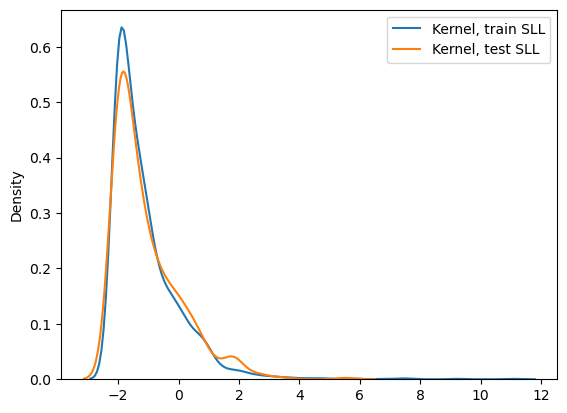

In [608]:
ax = sns.kdeplot(- kernel_log_loss - trivial_log_loss, label="Kernel, train SLL")
ax = sns.kdeplot(- kernel_log_loss_test - trivial_log_loss_test, label="Kernel, test SLL")
ax.legend()

In [532]:
feature_posterior_mean = feature_advi_model_idata.posterior.mean(dim=["chain", "draw"])

direct_predictions = []

for i in tqdm(train_df.index):
    subj = train_df.loc[i]

    single_B_spline_age = patsy.build_design_matrices(
        [prediction_B_spline_age.design_info],
        {"xi": [((subj['age'] - age.mean()) / age.std())], "knots": knot_list[1:-1]}
    )

    y_ppc_mu_mean = (
        feature_posterior_mean['intercept_sex'].isel(sex=int(subj['sex'])) +
        feature_posterior_mean['intercept_site'].isel(site=subj['siteCode']) +
        xr.dot(
            xr.DataArray(np.asarray(single_B_spline_age)[0], dims=["obs_id", "splines"]),
            feature_posterior_mean['w_age']
        )
    ) * train_df['thickness'].std() + train_df['thickness'].mean()
    direct_predictions.append(y_ppc_mu_mean)


  0%|          | 0/1978 [00:00<?, ?it/s]

In [609]:
feature_posterior_mean = feature_advi_model_idata.posterior.mean(dim=["chain", "draw"])

direct_predictions_sigma = []

for i in tqdm(train_df.index):
    subj = train_df.loc[i]

    single_B_spline_age = patsy.build_design_matrices(
        [prediction_B_spline_age.design_info],
        {"xi": [((subj['age'] - age.mean()) / age.std())], "knots": knot_list[1:-1]}
    )

    y_ppc_sigma_mean = (
        feature_posterior_mean['error_sex'].isel(sex=int(subj['sex'])) +
        feature_posterior_mean['error_site'].isel(site=subj['siteCode']) +
        xr.dot(
            xr.DataArray(np.asarray(single_B_spline_age)[0], dims=["obs_id", "splines"]),
            feature_posterior_mean['w_error_age']
        )
    ) * train_df['thickness'].std()
    direct_predictions_sigma.append(y_ppc_sigma_mean)


  0%|          | 0/1978 [00:00<?, ?it/s]

In [611]:
# kernel model
direct_log_loss = np.array(
    [
        stats.norm.logpdf(train_df.iloc[i]['thickness'], loc=direct_predictions[i], scale=direct_predictions_sigma[i])
        for i in tqdm(range(train_df.shape[0]))
    ]
).T[0]


  0%|          | 0/1978 [00:00<?, ?it/s]

In [536]:
feature_posterior_mean = feature_advi_model_idata.posterior.mean(dim=["chain", "draw"])

direct_test_predictions = []

for i in tqdm(test_df.index):
    subj = test_df.loc[i]

    single_B_spline_age = patsy.build_design_matrices(
        [prediction_B_spline_age.design_info],
        {"xi": [((subj['age'] - age.mean()) / age.std())], "knots": knot_list[1:-1]}
    )

    y_ppc_mu_mean = (
        feature_posterior_mean['intercept_sex'].isel(sex=int(subj['sex'])) +
        feature_posterior_mean['intercept_site'].isel(site=subj['siteCode']) +
        xr.dot(
            xr.DataArray(np.asarray(single_B_spline_age)[0], dims=["obs_id", "splines"]),
            feature_posterior_mean['w_age']
        )
    ) * train_df['thickness'].std() + train_df['thickness'].mean()
    direct_test_predictions.append(y_ppc_mu_mean)


  0%|          | 0/495 [00:00<?, ?it/s]

In [610]:
feature_posterior_mean = feature_advi_model_idata.posterior.mean(dim=["chain", "draw"])

direct_test_predictions_sigma = []

for i in tqdm(test_df.index):
    subj = test_df.loc[i]

    single_B_spline_age = patsy.build_design_matrices(
        [prediction_B_spline_age.design_info],
        {"xi": [((subj['age'] - age.mean()) / age.std())], "knots": knot_list[1:-1]}
    )

    y_ppc_sigma_mean = (
        feature_posterior_mean['error_sex'].isel(sex=int(subj['sex'])) +
        feature_posterior_mean['error_site'].isel(site=subj['siteCode']) +
        xr.dot(
            xr.DataArray(np.asarray(single_B_spline_age)[0], dims=["obs_id", "splines"]),
            feature_posterior_mean['w_error_age']
        )
    ) * train_df['thickness'].std()
    direct_test_predictions_sigma.append(y_ppc_sigma_mean)


  0%|          | 0/495 [00:00<?, ?it/s]

In [612]:
# kernel model
direct_log_loss_test = np.array(
    [
        stats.norm.logpdf(test_df.iloc[i]['thickness'], loc=direct_test_predictions[i], scale=direct_test_predictions_sigma[i])
        for i in tqdm(range(test_df.shape[0]))
    ]
).T[0]


  0%|          | 0/495 [00:00<?, ?it/s]

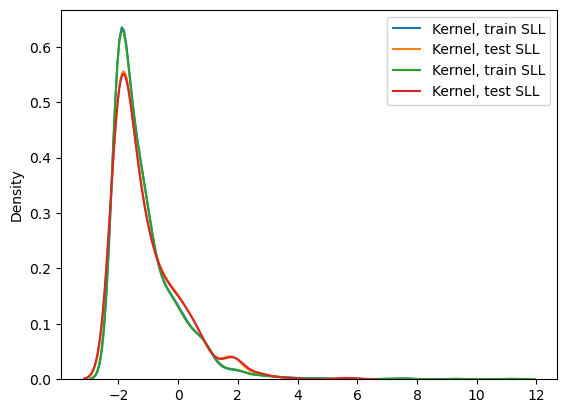

In [613]:
ax = sns.kdeplot(- kernel_log_loss - trivial_log_loss, label="Kernel, train SLL")
ax = sns.kdeplot(- kernel_log_loss_test - trivial_log_loss_test, label="Kernel, test SLL")
ax = sns.kdeplot(- direct_log_loss - trivial_log_loss, label="Kernel, train SLL")
ax = sns.kdeplot(- direct_log_loss_test - trivial_log_loss_test, label="Kernel, test SLL")
ax.legend()


In [720]:
kernel_advi_model_idata.training

<xarray.Dataset>
Dimensions:         (chain: 1, draw: 1)
Coordinates:
  * chain           (chain) int64 0
  * draw            (draw) int64 0
Data variables:
    thickness_mean  (chain, draw) float64 658.1
    thickness_std   (chain, draw) float64 52.1
    sample_size     (chain, draw) int64 1978
Attributes:
    created_at:     2023-12-29T07:47:00.850480
    arviz_version:  0.12.1